In [2]:
import numpy as np
import pandas as pd
import scipy
from scipy.spatial import distance
import itertools

import json
import warnings
from functools import wraps, partial
from multiprocessing.dummy import Pool
from time import time
import os
import sys
import pickle
import math
import gc
from copy import deepcopy

from datetime import datetime, date, timedelta

from sklearn_xarray import wrap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.utils import check_random_state

import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.pyplot as plt
from matplotlib import animation
import plotly.graph_objects as go
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.io.shapereader as shpreader
import seaborn as sns
import networkx as nx
import pydot
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['axes.titlesize'] = 14
sns.set_context("notebook", rc={"axes.labelsize":14,"axes.titlesize":14, "legend.fontsize":14})
path  = "energy_immgs"
%matplotlib inline

In [2]:
predictions = pd.read_csv('W:/UK/Research/Private/WEATHER/STAGE_ABALDO/scripts/predictions/predictions_VAE.csv',
                         header=[0, 1], index_col = 0)
for method in predictions.columns.get_level_values(0).unique():
    predictions[(method, 'Prediction')] = predictions.xs(method, axis=1).apply(
        lambda x: predictions.xs(method, axis=1).columns[np.argmax(x)], axis = 1)
predictions.index = pd.to_datetime(predictions.index, dayfirst = True)

In [3]:
pcs = pd.read_csv('W:/UK/Research/Private/WEATHER/STAGE_ABALDO/scripts/files/pcs.csv', header = 0, index_col = 0)
pcs.index = pd.to_datetime(pcs.index)

## Utils

In [4]:
import warnings
import functools

def no_warning(func):
    """This is a decorator which can be used to mark functions
    as deprecated. It will result in a warning being emitted
    when the function is used."""
    @wraps(func)
    def new_func(*args, **kwargs):
        warnings.simplefilter('ignore')  # turn off filter
        return func(*args, **kwargs)
    return new_func

def filter_by_preds(df, predictions, model):
    preds = predictions.xs('Prediction', level =1, axis =1)
    #accurate_preds = preds[preds.eq(preds.iloc[:, 0], axis=0).all(1)].apply(lambda x: x.unique()[0], axis=1)
    accurate_preds = preds[model]
    
    df = df.loc[df.index.intersection(accurate_preds.index)]
    df['Regime'] = accurate_preds[df.index.intersection(accurate_preds.index)]
    print(df['Regime'].value_counts())
    
    return df

## Plotting

In [5]:
@no_warning
def plot_density(start_date, end_date, x, y, z = None,  regimes = True, **kwargs):
    '''
    Method to plot the density of two variables
    Args:
    - start_date: str indicating the start date to consider
    - end_date: str indicating the end date to consider
    - x: pd.Series containing the elements to plot for the variable x
    - y: pd.Series containing the elements to plot for the variable y
    - regimes: boolean indicating whether the reference of the regimes must be inserted
    '''
    
    
    if 'ax' not in kwargs:
        fig, ax = plt.subplots(figsize=(7,7))#subplot_kw={'projection': 'polar'})
    
    else:
        ax = kwargs['ax']
    
    if z is None:
        x,y = np.squeeze(x.loc[start_date:end_date]), np.squeeze(y.loc[start_date:end_date])
        sns.kdeplot(x,y, shade = False, ax=ax, cmap = 'RdBu_r', levels = 50, alpha=.7,
                    label = kwargs['label'] if 'label' in kwargs else None)
    else:
        x,y = x[z.index.intersection(x.index)], y[z.index.intersection(y.index)]
        sns.scatterplot(x,y, ax = ax, hue = z, palette = 'RdBu_r')
    
        
    if regimes:
        ax.vlines(0, -3, 3, linewidth=.1, colors='k', zorder = 100)
        ax.hlines(0, -3, 3, linewidth=.1, colors='k', zorder = 100)
        ax.plot([-3,3],[-3,3], linewidth=.1, c='k', zorder = 100)
        ax.plot([-3,3],[3,-3], linewidth=.1, c='k', zorder = 100)
        circle = plt.Circle((0,0), 1, linewidth=.1, edgecolor='k', facecolor = None, fill = False)
        ax.add_patch(circle)
        ax.text(-2.95, 0., "NAO-",size ='large', weight = 'bold')
        ax.text(0., -2.95, "BL-",size ='large', weight = 'bold')
        ax.text(0., 2.85, "BL+",size ='large', weight = 'bold')
        ax.text(2.4, 0., "NAO+",size ='large', weight = 'bold')
        ax.set_xlim(-3,3)
        ax.set_ylim(-3,3)
    
    if 'label' in kwargs:
        ax.legend()
    
    if 'savefig' in kwargs:
        plt.savefig(kwargs['savefig'])
    
    if 'ax' not in kwargs:
        plt.show()


def plot_lines(df, cols, title, **kwargs):
    with plt.style.context('seaborn'):
        fig, axs = plt.subplots(1,len(cols), figsize = (7.5*len(cols),15))
        for i, (ax,col) in enumerate(zip(axs.flat, cols)):
            df[col].plot(kind='line', ax = ax, linewidth = 2.1, linestyle ='-.')
            
            if not isinstance(col, str):
                ax.fill_between(df.index.values, df[col[0]], df[col[1]], where = df[col[0]] > df[col[1]],
                                interpolate = True, alpha =.25)
                ax.fill_between(df.index.values, df[col[0]], df[col[1]], where = df[col[0]] < df[col[1]],
                                interpolate = True, alpha =.25)
            ax.legend()
        
        fig.tight_layout()
        plt.savefig(title)
        plt.show()
        
            
def plot_bands(df, by, cols, xlabel, ylabel, title, **kwargs):
    with plt.style.context('seaborn'):
        fig, axs = plt.subplots(1,len(cols), figsize = (7.5*len(cols),7), sharey=True if 'sharey' in kwargs else False)
        grouped_df = df.groupby(by).agg({k:["mean", "std"] for k in df.columns})
        for ax, col_ in zip(axs.flat, cols):
            grouped_df.xs('mean', level = 1, axis = 1) [col_].\
                plot(kind = 'line', ax = ax, xlabel = xlabel, ylabel = ylabel, linewidth = 2.1, linestyle='-.')
            if isinstance(col_, str):
                col = col_
                ax.fill_between(grouped_df.index.values,
                             grouped_df.xs('mean', level = 1, axis = 1)[col] - 2*grouped_df.xs('std', level = 1, axis = 1)[col],
                             grouped_df.xs('mean', level = 1, axis = 1)[col] + 2*grouped_df.xs('std', level = 1, axis = 1)[col],
                            alpha = .25, label = "95% C.I. " + col)
            else:
                for col in col_:
                    ax.fill_between(grouped_df.index.values,
                                     grouped_df.xs('mean', level = 1, axis = 1)[col] - 2*grouped_df.xs('std', level = 1, axis = 1)[col],
                                     grouped_df.xs('mean', level = 1, axis = 1)[col] + 2*grouped_df.xs('std', level = 1, axis = 1)[col],
                                    alpha = .25, label = "95% C.I. " + col)
            ax.legend()
        
        fig.tight_layout()
        plt.savefig(title)
        plt.show()

def plot_3Dpcs(df, pcs,  cols, title):
    fig, axs = plt.subplots(1, len(cols), figsize=(len(cols) * 7.5, 7), sharex = True, sharey = True)
    for ax, col in zip(axs.flat, cols):
        plot_density(start_date = df.index.values[0], end_date = df.index.values[-1],
                  x = pcs['PC1'], y = pcs['PC2'], z = df[col], ax = ax)
    
    fig.tight_layout()
    plt.savefig(title)
    plt.show()
            
def plot_densities_vs_variable(df, x_col, y_cols, title):
    fig, axs = plt.subplots(len(y_cols),4, figsize=(30,len(y_cols) * 7.5), sharex = True, sharey='row')
    for i, y_col in enumerate(y_cols):
        for j, (ax,regime) in enumerate(zip(axs.flat[i*4:(i+1)*4],sorted(df['Regime'].unique()))):
            plot_density(df[df['Regime'] == regime].index.values[0],
                         df[df['Regime'] == regime].index.values[-1],
                         df[df['Regime'] == regime][x_col],
                         df[df['Regime'] == regime][y_col], label = regime,
                         ax = ax, regimes = False)
    
    fig.tight_layout()
    plt.savefig(title)
    plt.show()
    
def compare_timeseries(df1, df2, cols, labels, title, **kwargs):
    with plt.style.context('seaborn'):
        fig, axs = plt.subplots(1, len(cols), figsize=(len(cols)*7.5,7))
        for i, (ax,col) in enumerate(zip(axs.flat, cols)):
            df1[col].plot(kind='line', label = col + "-" + labels[0], ax = ax, linewidth = 2.1, linestyle ='-.')
            df2[col].plot(kind='line', label = col + "-" + labels[1], ax = ax, linewidth = 2.1, linestyle ='-.')
            if not isinstance(col, str):
                ax.fill_between(df1.index, df1[col], df2[col], where = df1[col] > df2[col],
                                interpolate = True, alpha =.25)
                ax.fill_between(df1.index, df1[col], df2[col], where = df1[col] < df2[col],
                                interpolate = True, alpha =.25)
            ax.legend()
        fig.tight_layout()
        plt.savefig(title)
        plt.show()

def compare_distributions(df1, df2, cols, labels, title, **kwargs):
    fig, axs = plt.subplots(1, len(cols), figsize=(len(cols)*7.5,7))
    for i, (ax,col) in enumerate(zip(axs.flat, cols)):
        if isinstance(col, str):
            sns.kdeplot(x=df1[col], label = col + "-" + labels[0], ax = ax,
                        bw_adjust = kwargs['bw_adjust'] if 'bw_adjust' in kwargs else 1)
            sns.kdeplot(x=df2[col], label = col + "-" + labels[1], ax = ax,
                        bw_adjust = kwargs['bw_adjust'] if 'bw_adjust' in kwargs else 1)
        else:
            for col_ in col:
                sns.kdeplot(x=df1[col], label = col + "-" + labels[0], ax = ax,
                        bw_adjust = kwargs['bw_adjust'] if 'bw_adjust' in kwargs else 1)
                sns.kdeplot(x=df2[col], label = col + "-" + labels[1], ax = ax,
                            bw_adjust = kwargs['bw_adjust'] if 'bw_adjust' in kwargs else 1)
        ax.legend()
    fig.tight_layout()
    plt.savefig(title)
    plt.show()

def compare_distributions_by_country(df1, df2, cols, labels, title, **kwargs):
    countries = df1.reset_index(level=0)['Country'].unique()
    fig, axs = plt.subplots(len(countries), len(cols),
                            figsize=(len(cols)*7.5,len(countries)*7.5), sharex = 'col')
    for i, country in enumerate(countries):
        for j, (ax,col) in enumerate(zip(axs.flat[i*len(cols):(i+1)*len(cols)], cols)):
            if isinstance(col, str):
                sns.kdeplot(x=df1.xs(country, level=0)[col], label = col + "-" + labels[0] + "-" + country,
                            ax = ax, bw_adjust = kwargs['bw_adjust'] if 'bw_adjust' in kwargs else 1)
                sns.kdeplot(x=df2.xs(country, level=0)[col], label = col + "-" + labels[1] + "-" + country,
                            ax = ax, bw_adjust = kwargs['bw_adjust'] if 'bw_adjust' in kwargs else 1)
            else:
                for col_ in col:
                    sns.kdeplot(x=df1.xs(country, level=0)[col], label = col + "-" + labels[0],
                                ax = ax, bw_adjust = kwargs['bw_adjust'] if 'bw_adjust' in kwargs else 1)
                    sns.kdeplot(x=df2.xs(country, level=0)[col], label = col + "-" + labels[1],
                                ax = ax, bw_adjust = kwargs['bw_adjust'] if 'bw_adjust' in kwargs else 1)
            ax.legend()
    fig.tight_layout()
    plt.savefig(title)
    plt.show()
    
def plot_distribution(df, cols, title,  **kwargs):
    fig, axs = plt.subplots(1, len(cols), figsize=(len(cols)*7.5,7))
    for i, (ax,col) in enumerate(zip(axs.flat, cols)):
        if isinstance(col, str):
            sns.kdeplot(x=df[col], label = col, ax = ax, bw_adjust = kwargs['bw_adjust'] if 'bw_adjust' in kwargs else 1)
        else:
            for col_ in col:
                sns.kdeplot(x=df[col_], label = col_, ax = ax, bw_adjust = kwargs['bw_adjust'] if 'bw_adjust' in kwargs else 1)
        ax.legend()
    fig.tight_layout()
    plt.savefig(title)
    plt.show()

    
def plot_distribution_by_regime(df, cols, predictions, model, title, **kwargs):
    fig, axs = plt.subplots(1,len(cols), figsize = (len(cols) * 7.5,7))
    for i, (col,ax) in enumerate(zip(cols, axs.flat)):
        for j, regime in enumerate(sorted(df['Regime'].unique())):
            sns.kdeplot(x = df[col], weights = predictions.loc[df.index,(model, regime)].values, label = regime, ax = ax,
                       bw_adjust = kwargs['bw_adjust'] if 'bw_adjust' in kwargs else 1)
        ax.legend()
    fig.tight_layout()
    plt.savefig(title)
    plt.show()
    
def plot_distribution_by_regime_monthly(df, cols, predictiosn, model, title, **kwargs):
    monthly_stats = df.copy()
    monthly_stats['Month'] = monthly_stats.index.month
    unique_months = monthly_stats['Month'].unique()
    fig, axs = plt.subplots(len(cols), len(unique_months),
                            figsize=(len(unique_months)*7.5, len(cols)*7.5), sharey ='row')
    for i, col in enumerate(cols):
        for j, (ax, month) in enumerate(zip(axs.flat[i*len(unique_months):(i+1)*len(unique_months)], unique_months)):
            for k, regime in enumerate(sorted(monthly_stats['Regime'].unique())):
                sns.kdeplot(x = monthly_stats[monthly_stats['Month']==month][col],
                            weights = predictions.loc[df.index[df.index.month == month], (model, regime)].values,
                            label = regime, ax = ax, bw_adjust = kwargs['bw_adjust'] if 'bw_adjust' in kwargs else 1)
            ax.set_title(datetime.strptime(str(month),"%m").strftime("%B"))
        ax.legend()
    fig.tight_layout()
    plt.savefig(title)
    plt.show()

def plot_scatter(df, x_col, y_col, title, **kwargs):
    with plt.style.context('seaborn'):
        fig, ax = plt.subplots(1,1, figsize=(7,7))
        ax.scatter(df[x_col], df[y_col], c = kwargs['c'] if 'c' in kwargs else None,
                   cmap = kwargs['cmap'] if 'cmap' in kwargs else None,
                   edgecolor ='k', s = 40)

        fig.tight_layout()
        plt.savefig(title)
        plt.show()
    
def plot_scatter_by_regime(df, x_col, y_col, title,  **kwargs):
    with plt.style.context('seaborn'):
        fig, ax = plt.subplots(1,1, figsize=(7,7))
        for i, regime in enumerate(sorted(df['Regime'].unique())):
            ax.scatter(df[df['Regime'] == regime][x_col], df[df['Regime'] == regime][y_col], label = regime,
                       c = kwargs['c'] if 'c' in kwargs else None,
                       cmap = kwargs['cmap'] if 'cmap' in kwargs else None,
                       edgecolor ='k', s = 40)

        ax.legend()
        fig.tight_layout()
        plt.savefig(title)
        plt.show()
    
def boxplot(df, grouping_cols, cols, title):
    fig, axs  = plt.subplots(1,len(cols), figsize = (len(cols) *7.5,7))
    for ax, col in zip(axs.flat, cols):
        groups = grouping_cols + [col]
        country_df[groups].boxplot(by=grouping_cols,meanline=True, showmeans=True, showcaps=True, 
                        showbox=True, showfliers=False, ax = ax, grid = False,
                        boxprops=dict(color='k'),
                        capprops=dict(color='k'),
                        whiskerprops=dict(color='k'),
                        meanprops=dict(color='r'),
                        medianprops=dict(color='b'))
        ax.set_ylabel(col)
        ax.set_xlabel('Regime')
    fig.suptitle('')
    plt.savefig(title)
    plt.show()

def boxplot_monthly(df, grouping_cols, cols, title):
    fig, axs  = plt.subplots(len(cols),1, figsize = (22.5,len(cols)* 7.5))
    monthly_stats = df.copy()
    monthly_stats['Month'] = monthly_stats.index.month
    for ax, col in zip(axs.flat, cols):
        groups = grouping_cols + [col]
        monthly_stats[groups].sort_values(by=grouping_cols).boxplot(by=grouping_cols,
                        meanline=True, showmeans=True, showcaps=True, 
                        showbox=True, showfliers=False, ax = ax, grid = False,
                        boxprops=dict(color='k'),
                        capprops=dict(color='k'),
                        whiskerprops=dict(color='k'),
                        meanprops=dict(color='r'),
                        medianprops=dict(color='b'))
        ax.axvline(x=3.5, color = 'k')
        ax.axvline(x=6.5, color = 'k')
        ax.axvline(x=9.5, color = 'k')
        ax.set_ylabel(col)
        ax.set_xlabel('(' + ','.join(grouping_cols) + ')')
    fig.suptitle('')
    plt.savefig(title)
    plt.show()

def plot_bars(df, cols, title):
    with plt.style.context('seaborn'):
        fig, axs = plt.subplots(1,4, figsize=(30,7), sharey = True)#, sharex = True)
        for ax, regime in zip(axs.flat, df.index.get_level_values(1).unique()):
            df[cols].xs(regime, level=1).\
            plot(kind='bar', ax = ax, xlabel = 'Month', ylabel = 'Load Factor', title = regime)
        plt.savefig(title)
        plt.show()


# Energy Data

In [10]:
synthetic_df = pd.read_csv("../src/dashboard/synthetic.csv", index_col = [0,1], parse_dates = True)

In [11]:
df = synthetic_df.copy()

## Measurements

In [6]:
READ_PATH = 'P:/CH/Weather Data/METEOLOGICA/OBSERVATIONS'
COUNTRIES = ['ES','FR', 'GE', 'UK', 'NE', 'IT']
TYPE = ["LOAD", "PRICE", "WIND", "SOLAR", "HYDRO"]
YEARS = list(map(str, range(2011, 2021)))

In [7]:
true_df = pd.DataFrame()
for country in os.listdir(READ_PATH):
    if country in COUNTRIES:
        for year in YEARS:
            for typeof in TYPE:
                try:
                    cols = ["Start", "End"]
                    
                    if typeof == "WIND":
                        if country == "UK":
                            cols += ["Wind Embedded Capacity", "Wind Capacity", "Wind Embedded Obs", "Wind Obs"]
                        elif country in ["NE","IT"]:
                            cols = ["Start", "Wind Obs", "Wind Capacity"]
                        else:
                            cols += ["Wind Capacity", "Wind Obs"]
                            
                            
                    elif typeof == "SOLAR":
                        if country == "UK":
                            cols += [ 'Solar Photo Capacity', '#solar', 'Solar Photo Obs']
                        elif country in ["NE", "IT"]:
                            cols = ["Start", "Solar Photo Obs", "Solar Photo Capacity"]
                        else:
                            cols += [ 'Solar Photo Capacity', 'Solar Photo Obs']
                            
                        if country == "ES":
                            cols += [ 'Solar Thermal Capacity', 'Solar Thermal Obs']
                            
                            
                    elif typeof == "LOAD":
                        if country not in ["NE","IT"]:
                            cols += ["Load"]
                        else:
                            cols = ["Start", "Load"]
                            
                            
                    elif typeof == "HYDRO":
                        if country == "ES":
                            cols += ["#hydro1", "#hydro2"]
                        
                        if country == "IT":
                            cols = ["Start", "Hydro RoR Obs", "Hydro Reservoir Obs"]
                        else:
                            cols += ['Hydro RoR Obs', 'Total Hydro Obs']
                            
                            
                    else:
                        cols += ["Price"]
                        
                    temp_df = pd.read_csv(
                        "/".join([READ_PATH, country, '_'.join([country, typeof, year])])+'.csv', sep=";",# index_col = [0,1],
                        skiprows = range(0,7), header = 0)
                    temp_df.columns = cols
                    temp_df.drop([label for label in temp_df.columns if '#' in label], axis=1, inplace = True)
                    temp_df['Country'] = country
                    temp_df.set_index(["Start", "Country"], inplace = True)
                    
                    if country in ["IT", "NE"]:
                        temp_df[
                            [col for col in temp_df.columns if any(el in col for el in ["Obs", "Capacity", "Load"])]] /= 1000
                    if country == "IT" and typeof == "HYDRO":
                        temp_df['Total Hydro Obs'] = temp_df['Hydro RoR Obs'] + temp_df['Hydro Reservoir Obs']
                        
                    true_df = true_df.append(temp_df)
                    
                except Exception as e:
                    print(e)
                    print("Corrupted or not existing file: {}".format('_'.join([country, typeof, year])+'.csv'))


[Errno 2] No such file or directory: 'P:/CH/Weather Data/METEOLOGICA/OBSERVATIONS/ES/ES_PRICE_2011.csv'
Corrupted or not existing file: ES_PRICE_2011.csv
[Errno 2] No such file or directory: 'P:/CH/Weather Data/METEOLOGICA/OBSERVATIONS/ES/ES_SOLAR_2011.csv'
Corrupted or not existing file: ES_SOLAR_2011.csv
[Errno 2] No such file or directory: 'P:/CH/Weather Data/METEOLOGICA/OBSERVATIONS/ES/ES_HYDRO_2011.csv'
Corrupted or not existing file: ES_HYDRO_2011.csv
[Errno 2] No such file or directory: 'P:/CH/Weather Data/METEOLOGICA/OBSERVATIONS/ES/ES_SOLAR_2012.csv'
Corrupted or not existing file: ES_SOLAR_2012.csv
[Errno 2] No such file or directory: 'P:/CH/Weather Data/METEOLOGICA/OBSERVATIONS/ES/ES_HYDRO_2012.csv'
Corrupted or not existing file: ES_HYDRO_2012.csv
[Errno 2] No such file or directory: 'P:/CH/Weather Data/METEOLOGICA/OBSERVATIONS/ES/ES_HYDRO_2013.csv'
Corrupted or not existing file: ES_HYDRO_2013.csv
[Errno 2] No such file or directory: 'P:/CH/Weather Data/METEOLOGICA/OBSERVA

[Errno 2] No such file or directory: 'P:/CH/Weather Data/METEOLOGICA/OBSERVATIONS/IT/IT_PRICE_2015.csv'
Corrupted or not existing file: IT_PRICE_2015.csv
[Errno 2] No such file or directory: 'P:/CH/Weather Data/METEOLOGICA/OBSERVATIONS/IT/IT_PRICE_2016.csv'
Corrupted or not existing file: IT_PRICE_2016.csv
[Errno 2] No such file or directory: 'P:/CH/Weather Data/METEOLOGICA/OBSERVATIONS/IT/IT_PRICE_2017.csv'
Corrupted or not existing file: IT_PRICE_2017.csv
[Errno 2] No such file or directory: 'P:/CH/Weather Data/METEOLOGICA/OBSERVATIONS/IT/IT_PRICE_2018.csv'
Corrupted or not existing file: IT_PRICE_2018.csv
[Errno 2] No such file or directory: 'P:/CH/Weather Data/METEOLOGICA/OBSERVATIONS/IT/IT_PRICE_2019.csv'
Corrupted or not existing file: IT_PRICE_2019.csv
[Errno 2] No such file or directory: 'P:/CH/Weather Data/METEOLOGICA/OBSERVATIONS/IT/IT_PRICE_2020.csv'
Corrupted or not existing file: IT_PRICE_2020.csv
[Errno 2] No such file or directory: 'P:/CH/Weather Data/METEOLOGICA/OBSERVA

In [8]:
true_df = true_df.reset_index().set_index('Start')
true_df.index = pd.to_datetime(true_df.index)
true_df = true_df.groupby('Country').resample('D').mean()

nan_mask = true_df['Wind Capacity'].isnull() & true_df['Wind Embedded Capacity'].isnull()
true_df['Total Wind Capacity'] = true_df['Wind Capacity'].fillna(0) + true_df['Wind Embedded Capacity'].fillna(0)
true_df['Total Wind Capacity'][nan_mask] = np.nan

nan_mask = true_df['Wind Obs'].isnull() & true_df['Wind Embedded Obs'].isnull()
true_df['Total Wind Obs'] = true_df['Wind Obs'].fillna(0) + true_df['Wind Embedded Obs'].fillna(0)
true_df['Total Wind Obs'][nan_mask] = np.nan

nan_mask = true_df['Solar Photo Capacity'].isnull() & true_df['Solar Thermal Capacity'].isnull()
true_df['Total Solar Capacity'] = true_df['Solar Photo Capacity'].fillna(0) + true_df['Solar Thermal Capacity'].fillna(0)
true_df['Total Solar Capacity'][nan_mask] = np.nan

nan_mask = true_df['Solar Photo Obs'].isnull() & true_df['Solar Thermal Obs'].isnull()
true_df['Total Solar Obs'] = true_df['Solar Photo Obs'].fillna(0) + true_df['Solar Thermal Obs'].fillna(0)
true_df['Total Solar Obs'][nan_mask] = np.nan

true_df['Hydro Reservoir Obs'] = true_df['Total Hydro Obs'] - true_df['Hydro Reservoir Obs']

true_df['Wind Load Factor'] = true_df['Total Wind Obs'] / true_df['Total Wind Capacity']
true_df['Solar Load Factor'] = true_df['Total Solar Obs'] / true_df['Total Solar Capacity']
true_df

Load  Wind Capacity  Wind Obs      Price  \
Country Start                                                       
ES      2011-01-01  23.916250          19.81  1.405417        NaN   
        2011-01-02  35.515833          19.96  6.663750        NaN   
        2011-01-03  33.070833          19.96  8.872083        NaN   
        2011-01-04  29.115000          20.02  5.954167        NaN   
        2011-01-05  21.687083          20.11  2.906667        NaN   
...                       ...            ...       ...        ...   
UK      2020-12-27  26.729167          17.98  8.686250  37.377083   
        2020-12-28  31.139583          17.98  2.384583  58.823333   
        2020-12-29  32.154583          17.98  3.880000  61.461250   
        2020-12-30  32.837500          17.98  3.694167  65.743333   
        2020-12-31  32.997083          17.98  3.626667  61.954167   

                    Solar Photo Capacity  Solar Photo Obs  \
Country Start                                               
ES      2011-01-01                   NaN              NaN   
        2011-01-02                   NaN              NaN   
        2011-01-03                   NaN              NaN   
        2011-01-04                   NaN              NaN   
        2011-01-05                   NaN              NaN   
...                                  ...              ...   
UK      2020-12-27                 13.08         0.646250   
        2020-12-28                 13.08         0.217083   
        2020-12-29                 13.08         0.249583   
        2020-12-30                 13.08         0.349167   
        2020-12-31                 13.08         0.469583   

                    Solar Thermal Capacity  Solar Thermal Obs  Hydro RoR Obs  \
Country Start                                                                  
ES      2011-01-01                     NaN                NaN            NaN   
        2011-01-02                     NaN                NaN            NaN   
        2011-01-03                     NaN                NaN            NaN   
        2011-01-04                     NaN                NaN            NaN   
        2011-01-05                     NaN                NaN            NaN   
...                                    ...                ...            ...   
UK      2020-12-27                     NaN                NaN            NaN   
        2020-12-28                     NaN                NaN            NaN   
        2020-12-29                     NaN                NaN            NaN   
        2020-12-30                     NaN                NaN            NaN   
        2020-12-31                     NaN                NaN            NaN   

                    Total Hydro Obs  Hydro Reservoir Obs  \
Country Start                                              
ES      2011-01-01              NaN                  NaN   
        2011-01-02              NaN                  NaN   
        2011-01-03              NaN                  NaN   
        2011-01-04              NaN                  NaN   
        2011-01-05              NaN                  NaN   
...                             ...                  ...   
UK      2020-12-27              NaN                  NaN   
        2020-12-28              NaN                  NaN   
        2020-12-29              NaN                  NaN   
        2020-12-30              NaN                  NaN   
        2020-12-31              NaN                  NaN   

                    Wind Embedded Capacity  Wind Embedded Obs  \
Country Start                                                   
ES      2011-01-01                     NaN                NaN   
        2011-01-02                     NaN                NaN   
        2011-01-03                     NaN                NaN   
        2011-01-04                     NaN                NaN   
        2011-01-05                     NaN                NaN   
...                                    ...              

In [9]:
true_df.describe()

Load  Wind Capacity      Wind Obs         Price  \
count  17386.000000   17860.000000  17467.000000  11666.000000   
mean      36.487540      16.843824      4.246643     41.398589   
std       15.292524      14.599547      4.856332     14.347586   
min        0.389130       2.430000      0.026000    -49.424783   
25%       27.316719       7.310000      1.315317     32.974896   
50%       32.984853      10.704010      2.677625     41.031250   
75%       47.173750      22.750000      5.271354     49.833437   
max       93.705000      61.260000     43.054583    367.604167   

       Solar Photo Capacity  Solar Photo Obs  Solar Thermal Capacity  \
count          15667.000000     14438.000000             2923.000000   
mean              13.977407         1.700944                2.272983   
std               13.020329         1.889253                0.081200   
min                1.062030         0.000000                1.949167   
25%                4.430000         0.549775                2.300000   
50%                8.700000         1.100417                2.300000   
75%               19.399050         2.071115                2.300000   
max               48.210000        12.101667                2.300000   

       Solar Thermal Obs  Hydro RoR Obs  Total Hydro Obs  Hydro Reservoir Obs  \
count        1978.000000    5766.000000      5756.000000          2145.000000   
mean            0.563677       3.336028         4.812989             3.834227   
std             0.417380       1.967752         2.207034             1.269215   
min             0.000000       0.156250         0.539583             1.215040   
25%             0.169277       1.654965         3.159678             2.865250   
50%             0.495000       3.431480         4.546875             3.688710   
75%             0.947891       4.835822         6.317895             4.665920   
max             1.539844       7.745833        11.507500             7.188500   

       Wind Embedded Capacity  Wind Embedded Obs  Total Wind Capacity  \
count             2545.000000        2345.000000         17860.000000   
mean                 5.073584           1.293923            17.566796   
std                  1.154389           0.648971            14.457002   
min                  2.520000           0.140417             2.430000   
25%                  4.040000           0.782917             7.610000   
50%                  5.140000           1.203333            12.950000   
75%                  6.140000           1.729167            22.780000   
max                  6.560000           4.260000            61.260000   

       Total Wind Obs  Total Solar Capacity  Total Solar Obs  \
count    17473.000000          15667.000000     14438.000000   
mean         4.418839             14.401479         1.778168   
std          4.918179             12.761520         1.888945   
min          0.026000              1.062030         0.000000   
25%          1.356250              6.310000         0.564585   
50%          2.804583              8.780000         1.194125   
75%          5.632727             19.399050         2.252474   
max         43.054583             48.210000        12.101667   

       Wind Load Factor  Solar Load Factor  
count      17473.000000       14438.000000  
mean           0.255992           0.125913  
std            0.165403           0.078523  
min            0.009077           0.000000  
25%            0.125832           0.061917  
50%            0.214621           0.119454  
75%            0.352523           0.173091  
max            0.905161           0.411605

## Synthetic Data

In [10]:
READ_PATH ='W:/UK/Research/Private/WEATHER/STAGE_ABALDO/dataset/Energy_Indicators_Copernicus'
FOLDERS = ['dataset-sis-energy-derived-reanalysis_ENERGY', 'dataset-sis-energy-derived-reanalysis_WEATHER']
COUNTRIES = ['BE','ES','FR', 'DE', 'IT', 'NL', 'UK']
TYPE = { 'dataset-sis-energy-derived-reanalysis_ENERGY':{
        "EDM_PWR": "Load", "HydroReservoir_CFR": "Hydro Load Factor", "HydroReservoir_PWR": "Hydro Reservoir Obs",
        "HydroRunOfRiver_CFR": "Hydro RoR Load Factor", "HydroRunOfRiver_PWR": "Hydro RoR Obs",
        "PV_CFR": "Solar Photo Load Factor", "PV_PWR": "Solar Photo Obs",
        "WindOffshore_CFR" : "Wind Offshore Load Factor", "WindOffshore_PWR": "Wind Offshore Obs",
        "WindOnshore_CFR" : "Wind Onshore Load Factor", "WindOnshore_PWR": "Wind Onshore Obs"
    },
        'dataset-sis-energy-derived-reanalysis_WEATHER': {
            "AirTemp_2m": "Temperature", "GHI": "Irradiance", "MeanSeaLevel": "Sea Level Pressure",
            "TotalPrecip": "Precipitation", "WindSpeed_10m": "Wind Speed (10m)", "WindSpeed_100m": "Wind Speed (100m)" 
        }
}
YEARS = "1979-2021"

In [11]:
synthetic_df = pd.DataFrame(columns = [v  for d in TYPE.values() for v in d.values()])

for folder in FOLDERS:
    for file in TYPE[folder]:
        tmp = pd.read_csv(os.path.join(READ_PATH, folder, file + "_" + YEARS + ".csv"),
                          comment = '#', index_col = 0, usecols = ['Date']+COUNTRIES)
        tmp.index = pd.to_datetime(tmp.index)
        #tmp = tmp[tmp.index.month.isin([12,1,2])]
        tmp.reset_index(inplace = True)
        tmp = pd.melt(tmp, id_vars = 'Date',  var_name = 'Country', value_vars = COUNTRIES, value_name = TYPE[folder][file])
        tmp['Country'] = tmp['Country'].map({'DE':'GE', 'NL':'NE', 'IT':'IT', 'UK':'UK', 'FR':'FR','BE':'BE','ES':'ES'})
        tmp.set_index(['Country','Date'], inplace = True)
        if synthetic_df.empty:
            synthetic_df = tmp.copy()
        else:
            synthetic_df = synthetic_df.append(tmp)

In [12]:
synthetic_df = synthetic_df.max(level=[0,1]).dropna(how='all', axis = 1)
synthetic_df[['Load','Hydro Reservoir Obs', 'Hydro RoR Obs', 'Solar Photo Obs', 'Wind Offshore Obs', 'Wind Onshore Obs']] /= 1000
synthetic_df['Temperature'] -= 273
nan_mask = synthetic_df['Wind Offshore Obs'].isnull() & synthetic_df['Wind Onshore Obs'].isnull()
synthetic_df['Total Wind Obs'] = synthetic_df['Wind Offshore Obs'].fillna(value = 0) +\
                                    synthetic_df['Wind Onshore Obs'].fillna(value = 0)
synthetic_df['Total Wind Obs'][nan_mask] = np.nan
synthetic_df['Total Wind Capacity'] = synthetic_df['Wind Offshore Obs'].fillna(value=0) / synthetic_df['Wind Offshore Load Factor'] +\
                            synthetic_df['Wind Onshore Obs'].fillna(value = 0) / synthetic_df['Wind Onshore Load Factor']
synthetic_df['Total Wind Capacity'][nan_mask] = np.nan
synthetic_df['Wind Load Factor'] = synthetic_df['Total Wind Obs'] / synthetic_df['Total Wind Capacity']
synthetic_df['Solar Load Factor'] = synthetic_df['Solar Photo Load Factor']
synthetic_df['Total Solar Capacity'] = synthetic_df['Solar Photo Obs'] / synthetic_df['Solar Load Factor']
synthetic_df['Total Solar Obs'] = synthetic_df['Solar Photo Obs']
synthetic_df

Load  Hydro Load Factor  Hydro Reservoir Obs  \
Country Date                                                          
BE      1979-01-01  10.7523                NaN                  NaN   
        1979-01-02  12.2079                NaN                  NaN   
        1979-01-03  12.3157                NaN                  NaN   
        1979-01-04  12.1409                NaN                  NaN   
        1979-01-05  12.3023                NaN                  NaN   
...                     ...                ...                  ...   
UK      2021-06-26  30.7170                NaN                  NaN   
        2021-06-27  29.6335                NaN                  NaN   
        2021-06-28  34.9890                NaN                  NaN   
        2021-06-29  35.1883                NaN                  NaN   
        2021-06-30  35.3371                NaN                  NaN   

                    Hydro RoR Load Factor  Hydro RoR Obs  \
Country Date                                               
BE      1979-01-01                    NaN            NaN   
        1979-01-02                    NaN            NaN   
        1979-01-03                    NaN            NaN   
        1979-01-04                    NaN            NaN   
        1979-01-05                    NaN            NaN   
...                                   ...            ...   
UK      2021-06-26                    NaN            NaN   
        2021-06-27                    NaN            NaN   
        2021-06-28                    NaN            NaN   
        2021-06-29                    NaN            NaN   
        2021-06-30                    NaN            NaN   

                    Solar Photo Load Factor  Solar Photo Obs  \
Country Date                                                   
BE      1979-01-01                 0.232619         0.927336   
        1979-01-02                 0.116128         0.462943   
        1979-01-03                 0.210750         0.840156   
        1979-01-04                 0.192886         0.768942   
        1979-01-05                 0.210612         0.839603   
...                                     ...              ...   
UK      2021-06-26                 0.183893              NaN   
        2021-06-27                 0.187218              NaN   
        2021-06-28                 0.177100              NaN   
        2021-06-29                 0.234968              NaN   
        2021-06-30                 0.211281              NaN   

                    Wind Offshore Load Factor  Wind Offshore Obs  \
Country Date                                                       
BE      1979-01-01                   0.071459                NaN   
        1979-01-02                   0.581635                NaN   
        1979-01-03                   0.280093                NaN   
        1979-01-04                   0.965406                NaN   
        1979-01-05                   0.800078                NaN   
...                                       ...                ...   
UK      2021-06-26                   0.118643           0.974829   
        2021-06-27                   0.210802           1.732054   
        2021-06-28                   0.104357           0.857448   
        2021-06-29                   0.141100           1.159350   
        2021-06-30                   0.112795           0.926779   

                    Wind Onshore Load Factor  ...  Sea Level Pressure  \
Country Date                                  ...                       
BE      1979-01-01                  0.237225  ...       101658.921958   
        1979-01-02                  0.643650  ...       102177.988917   
        1979-01-03                  0.370267  ...       102325.213417   
        1979-01-04                  0.946680  ...       101215.674750   
        1979-01-05                  0.726104  ...       102324.947292   
...                                      ...  ...                 ...   
UK      2021-06-

## Overall Dataset

In [13]:
df = synthetic_df.copy()
df.loc[true_df.index, true_df.columns.intersection(df.columns)] = true_df
other_cols = [c for c in true_df.columns if c not in true_df.columns.intersection(df.columns)]
df = pd.concat([df, true_df[other_cols]], axis=1)
df

Load  Hydro Load Factor  Hydro Reservoir Obs  \
BE 1979-01-01  10.7523                NaN                  NaN   
   1979-01-02  12.2079                NaN                  NaN   
   1979-01-03  12.3157                NaN                  NaN   
   1979-01-04  12.1409                NaN                  NaN   
   1979-01-05  12.3023                NaN                  NaN   
...                ...                ...                  ...   
UK 2021-06-26  30.7170                NaN                  NaN   
   2021-06-27  29.6335                NaN                  NaN   
   2021-06-28  34.9890                NaN                  NaN   
   2021-06-29  35.1883                NaN                  NaN   
   2021-06-30  35.3371                NaN                  NaN   

               Hydro RoR Load Factor  Hydro RoR Obs  Solar Photo Load Factor  \
BE 1979-01-01                    NaN            NaN                 0.232619   
   1979-01-02                    NaN            NaN                 0.116128   
   1979-01-03                    NaN            NaN                 0.210750   
   1979-01-04                    NaN            NaN                 0.192886   
   1979-01-05                    NaN            NaN                 0.210612   
...                              ...            ...                      ...   
UK 2021-06-26                    NaN            NaN                 0.183893   
   2021-06-27                    NaN            NaN                 0.187218   
   2021-06-28                    NaN            NaN                 0.177100   
   2021-06-29                    NaN            NaN                 0.234968   
   2021-06-30                    NaN            NaN                 0.211281   

               Solar Photo Obs  Wind Offshore Load Factor  Wind Offshore Obs  \
BE 1979-01-01         0.927336                   0.071459                NaN   
   1979-01-02         0.462943                   0.581635                NaN   
   1979-01-03         0.840156                   0.280093                NaN   
   1979-01-04         0.768942                   0.965406                NaN   
   1979-01-05         0.839603                   0.800078                NaN   
...                        ...                        ...                ...   
UK 2021-06-26              NaN                   0.118643           0.974829   
   2021-06-27              NaN                   0.210802           1.732054   
   2021-06-28              NaN                   0.104357           0.857448   
   2021-06-29              NaN                   0.141100           1.159350   
   2021-06-30              NaN                   0.112795           0.926779   

               Wind Onshore Load Factor  ...  Total Solar Obs  Wind Capacity  \
BE 1979-01-01                  0.237225  ...         0.927336            NaN   
   1979-01-02                  0.643650  ...         0.462943            NaN   
   1979-01-03                  0.370267  ...         0.840156            NaN   
   1979-01-04                  0.946680  ...         0.768942            NaN   
   1979-01-05                  0.726104  ...         0.839603            NaN   
...                                 ...  ...              ...            ...   
UK 2021-06-26                  0.189487  ...              NaN            NaN   
   2021-06-27                  0.313304  ...              NaN            NaN   
   2021-06-28                  0.151198  ...              NaN            NaN   
   2021-06-29                  0.130600  ...              NaN            NaN   
   2021-06-30                  0.089747  ...              NaN            NaN   

               Wind Obs  Price  Solar Photo Capacity  Solar Thermal Capacity  \
BE 1979-01-01       NaN    NaN                   NaN                     NaN   
   1979-01-02       NaN    NaN                   NaN                     NaN   
   1979-01-03       NaN    NaN                   NaN                     NaN   
   1979-01-04       Na

## Comparison Synthetic and Measurements

In [ ]:
try:
    os.makedirs(os.path.join(path, 'Comparison'))
except OSError as oserr:
    print(oserr)

In [475]:
columns = [c for c in true_df.columns.intersection(synthetic_df.columns)]
tmp, tmp_synth = true_df[columns], synthetic_df[columns]
countries = tmp.index.get_level_values(0).intersection(tmp_synth.index.get_level_values(0))
tmp = tmp.loc[countries]
tmp_synth = tmp_synth.loc[countries]

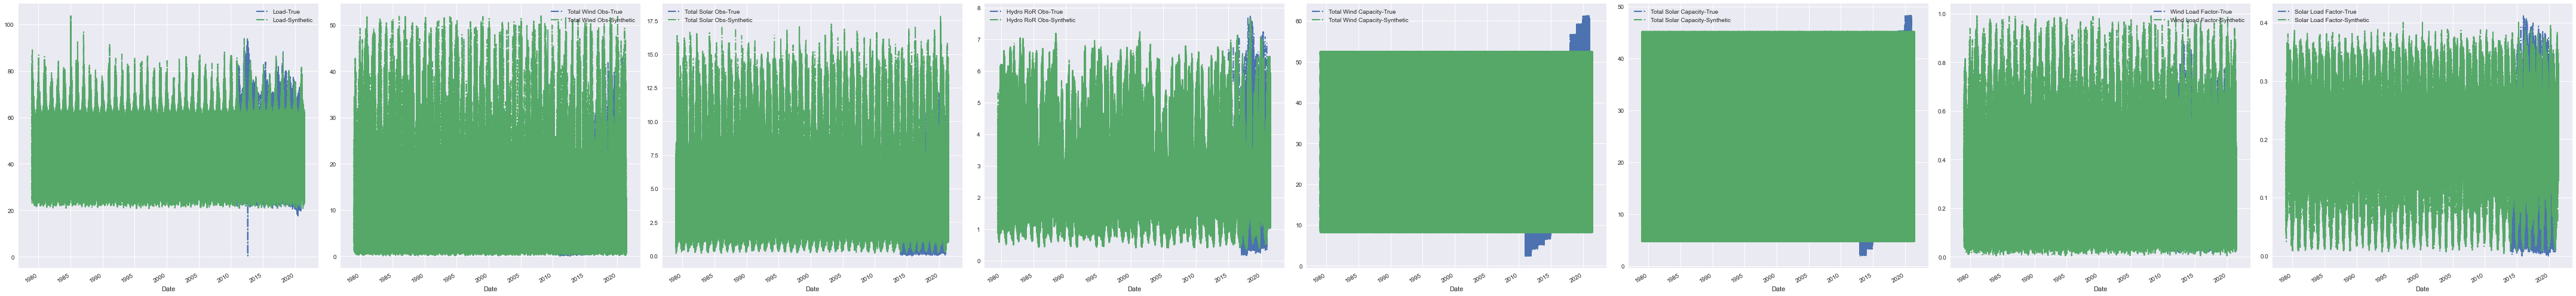

In [499]:
compare_timeseries(tmp.reset_index(level=0), tmp_synth.reset_index(level=0), columns, ['True', 'Synthetic'],
                      os.path.join(path, 'Comparison', 'energy_vars_ts.png'))

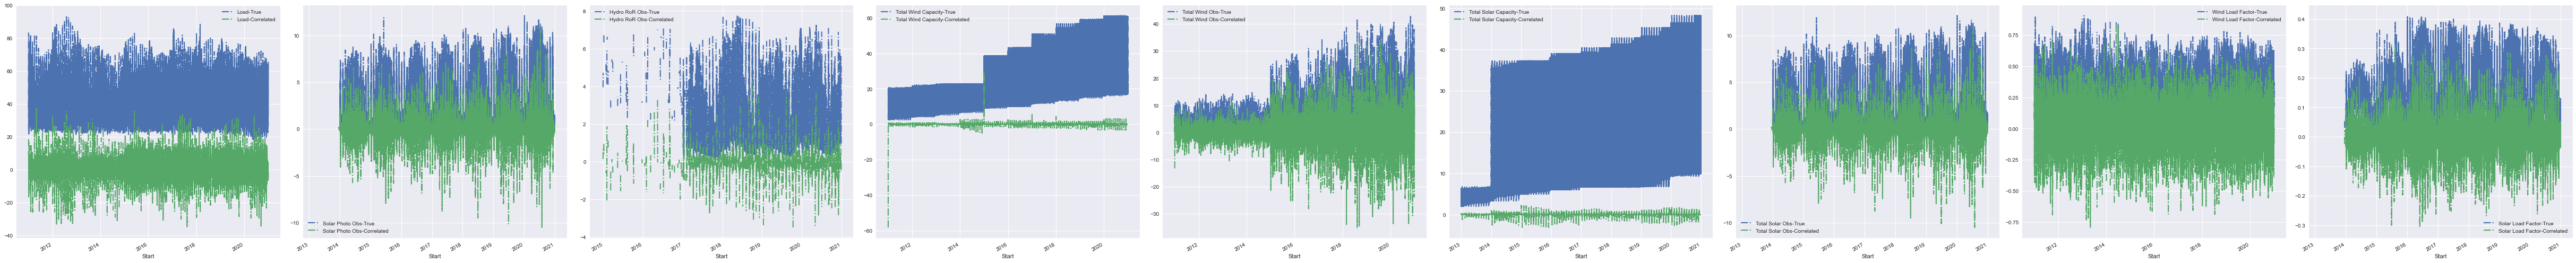

In [520]:
compare_timeseries(tmp.reset_index(level=0), tmp.diff().reset_index(level=0), columns, ['True', 'Correlated'],
                      os.path.join(path, 'Comparison', 'energy_vars_ts_correlated.png'))

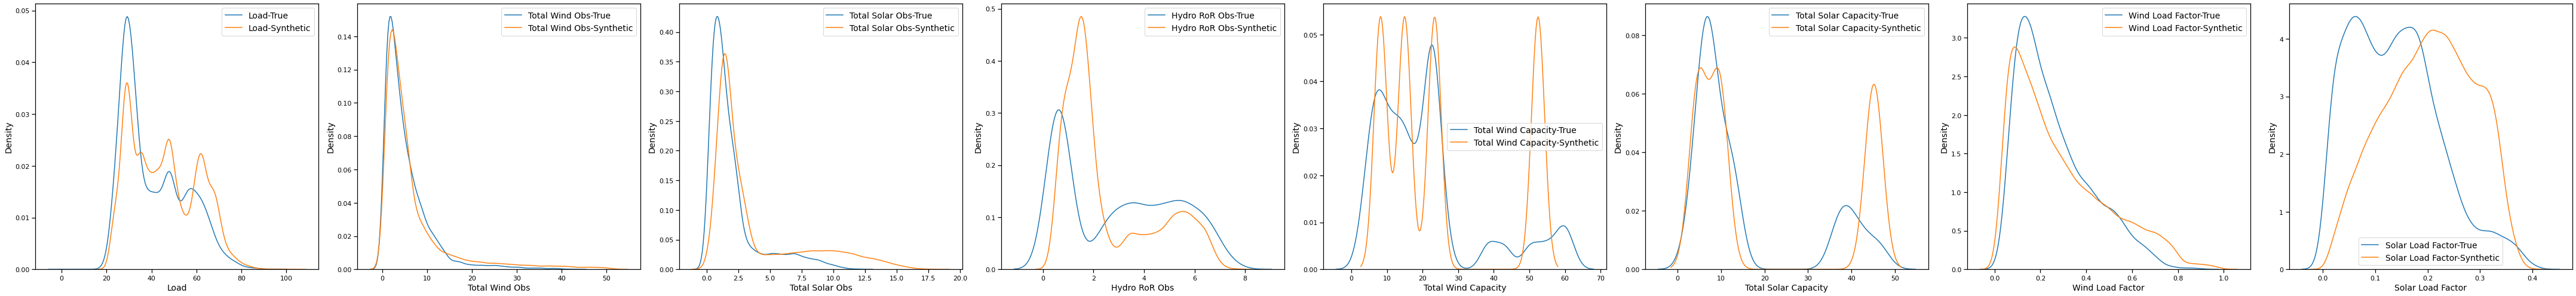

In [497]:
compare_distributions(tmp, tmp_synth, columns, ['True', 'Synthetic'],
                      os.path.join(path, 'Comparison', 'energy_vars_distribution.png'))

No handles with labels found to put in legend.


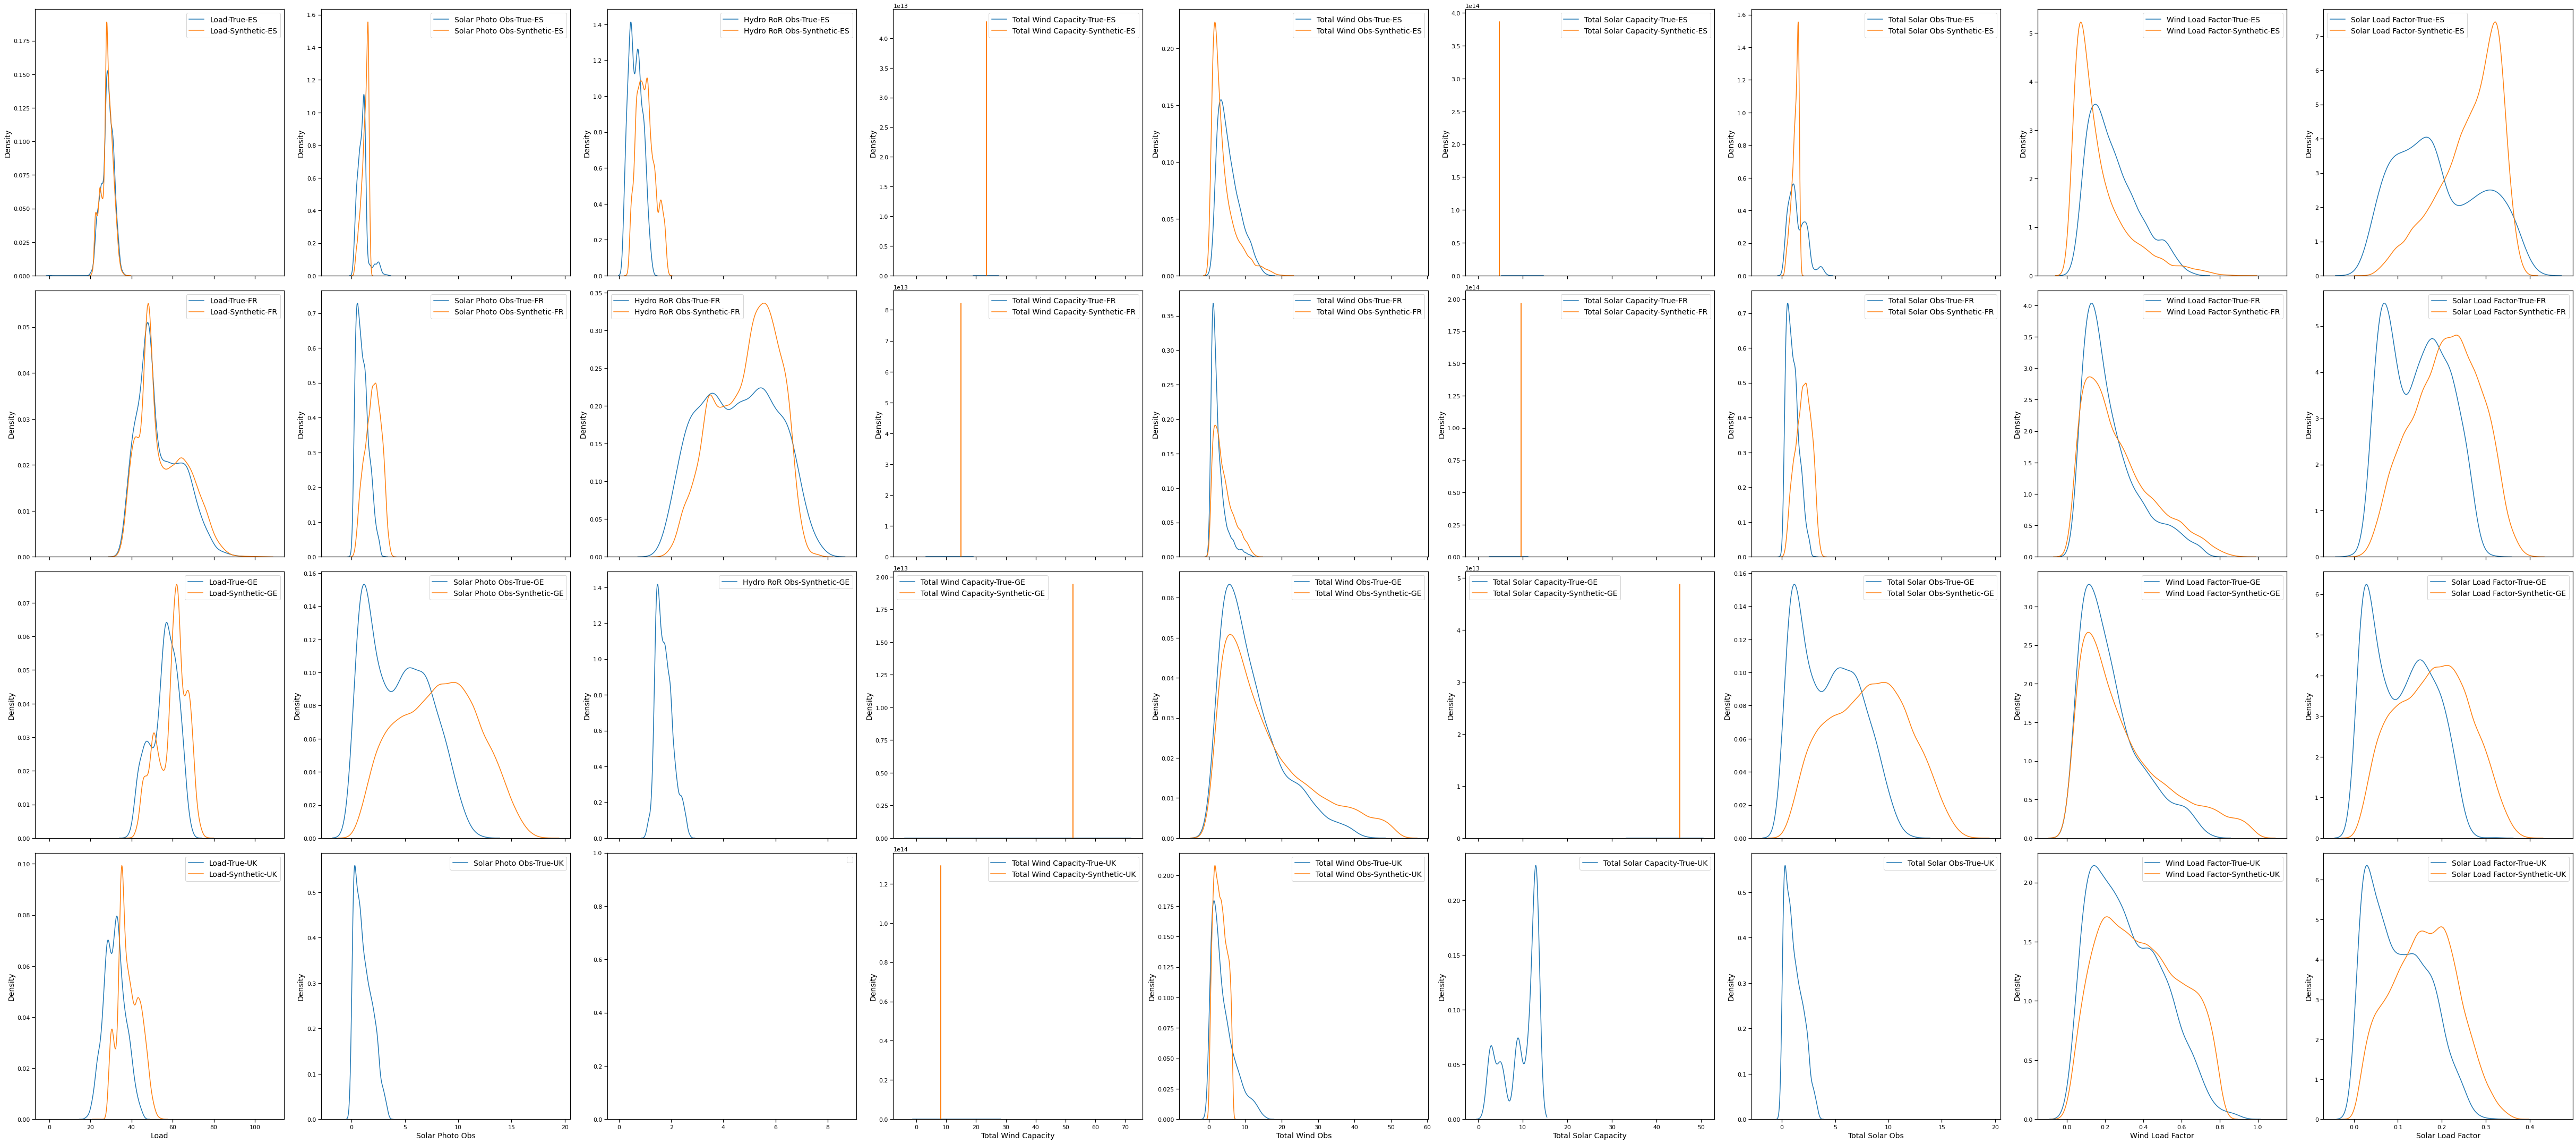

In [528]:
compare_distributions_by_country(tmp, tmp_synth, columns, ['True', 'Synthetic'],
                      os.path.join(path, 'Comparison', 'energy_vars_distribution_by_country.png'))

In [519]:
stats = pd.DataFrame(columns = pd.MultiIndex.from_tuples(
                    itertools.product(['Mean', 'Std', 'Skewness', 'Kurtosis'],['True', 'Synthetic'])),
                    index = columns)
for col in stats.index:
    for dtf, ind in zip([tmp, tmp_synth], ['True','Synthetic']):
        val = dtf[col]
        mean = val.mean(skipna=True)
        stats.loc[col, ('Mean', ind)] = mean
        std = val.std(skipna=True)
        stats.loc[col, ('Std', ind)] = std
        stats.loc[col, ('Skewness', ind)] = ((val**3).mean(skipna=True) - 3*mean*(std**2) - mean**3) / std**3
        stats.loc[col, ('Kurtosis', ind)] = ((val - mean)**4).mean(skipna=True) / std**4
stats

Mean                  Std             Skewness  \
                          True Synthetic       True  Synthetic      True   
Load                   40.8805   45.5132    14.0492    14.7682  0.671847   
Solar Photo Obs         1.8951   3.80119    2.10396     3.7557    2.1324   
Hydro RoR Obs           3.0406   2.55428    2.23174    1.83657  0.217238   
Total Wind Capacity    20.9376   24.7586    15.0535    16.8668   1.32102   
Total Wind Obs         5.34819   6.77973    5.31264    8.26314   2.55756   
Total Solar Capacity   15.3352   19.8532    14.0176    18.0175    1.2448   
Total Solar Obs        2.00554   3.80119    2.09247     3.7557   2.02612   
Wind Load Factor      0.259745  0.283677   0.160011   0.206295  0.908742   
Solar Load Factor     0.137439  0.203515  0.0847451  0.0845932  0.585366   

                               Kurtosis            
                     Synthetic     True Synthetic  
Load                  0.330237  2.38993   2.01643  
Solar Photo Obs        1.44259   6.9891   3.88017  
Hydro RoR Obs         0.927318  1.62949   2.43001  
Total Wind Capacity   0.821059   3.9616   2.07519  
Total Wind Obs         2.73096  12.0012   11.0993  
Total Solar Capacity  0.668725  2.81407   1.49994  
Total Solar Obs        1.44259  6.69994   3.88017  
Wind Load Factor      0.898576  3.18528   2.97857  
Solar Load Factor    -0.147986  2.87289   2.15488

## EU-7

In [12]:
preds = predictions.xs('Prediction', level =1, axis =1)
accurate_preds = preds['GMM']

In [13]:
df = df.reset_index(level=0)
df.loc[df.index.intersection(accurate_preds.index)]

Country     Load  Hydro Load Factor  Hydro Reservoir Obs  \
Date                                                                  
1979-01-01      BE  10.7523                NaN                  NaN   
1979-01-01      ES  22.9115                NaN                  NaN   
1979-01-01      FR  76.3905                NaN                  NaN   
1979-01-01      GE  55.2080                NaN                  NaN   
1979-01-01      IT  24.3998                NaN                  NaN   
...            ...      ...                ...                  ...   
2021-02-28      FR  54.2632           0.243345              2.00289   
2021-02-28      GE  50.8760           0.094444              0.10200   
2021-02-28      IT  28.3108           0.229833              1.00552   
2021-02-28      NE  11.4309                NaN                  NaN   
2021-02-28      UK  38.0186                NaN                  NaN   

            Hydro RoR Load Factor  Hydro RoR Obs  Solar Photo Load Factor  \
Date                                                                        
1979-01-01                    NaN            NaN                 0.232619   
1979-01-01                    NaN            NaN                 0.141595   
1979-01-01                    NaN            NaN                 0.214993   
1979-01-01                    NaN            NaN                 0.152666   
1979-01-01                    NaN            NaN                 0.197953   
...                           ...            ...                      ...   
2021-02-28               0.524170        5.41309                 0.343060   
2021-02-28               0.408512        1.60496                 0.248066   
2021-02-28               0.338182        3.51337                 0.316504   
2021-02-28                    NaN            NaN                 0.143071   
2021-02-28                    NaN            NaN                 0.196309   

            Solar Photo Obs  Wind Offshore Load Factor  Wind Offshore Obs  \
Date                                                                        
1979-01-01         0.927336                   0.071459                NaN   
1979-01-01         0.674489                   0.391357                NaN   
1979-01-01         2.067587                   0.410155           0.029818   
1979-01-01         6.897281                   0.543457                NaN   
1979-01-01         3.980367                   0.709303           0.017874   
...                     ...                        ...                ...   
2021-02-28         3.299209                   0.341668           0.024839   
2021-02-28        11.207372                   0.117361                NaN   
2021-02-28         6.364134                   0.171734           0.004328   
2021-02-28         0.080406                   0.031843           0.030474   
2021-02-28              NaN                   0.214651           1.763678   

            ...  Sea Level Pressure  Precipitation  Wind Speed (10m)  \
Date        ...                                                        
1979-01-01  ...       101658.921958       0.000045          2.811933   
1979-01-01  ...       101895.371208       0.002402          4.201859   
1979-01-01  ...       101573.884458       0.000693          3.805777   
1979-01-01  ...       101100.498750       0.000562          4.127951   
1979-01-01  ...        99851.072833       0.002362          4.781798   
...         ...                 ...            ...               ...   
2021-02-28  ...       102940.918875       0.000333          3.456365   
2021-02-28  ...       103656.782500       0.000035          2.438426   
2021-02-28  ...       102918.168125       0.000100          2.337425   
2021-02-28  ...       103795.285417       0.000041          2.263925   
2021-02-28  ...       103747.078833       0.000082          2.324893   

            Wind Speed (100m)  Total Wind Obs  Total Wind Capacity  \
Date                                                                 
1979-0

In [14]:
try:
    os.makedirs(os.path.join(path, 'EU-7'))
except OSError as oserr:
    print(oserr)

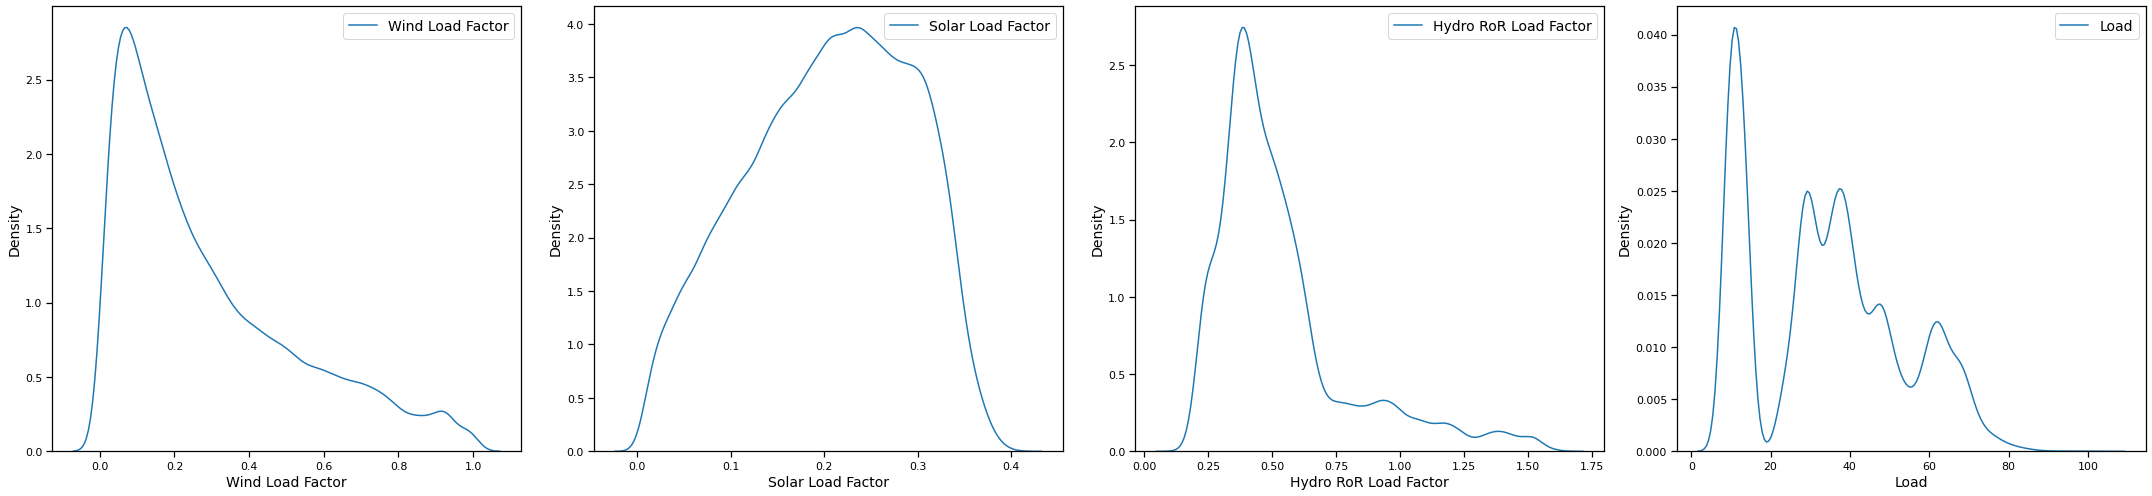

In [15]:
plot_distribution(df, ['Wind Load Factor', 'Solar Load Factor', 'Hydro RoR Load Factor', 'Load'],
                 os.path.join(path, 'EU-7', 'energy_vars_distribution.png'))

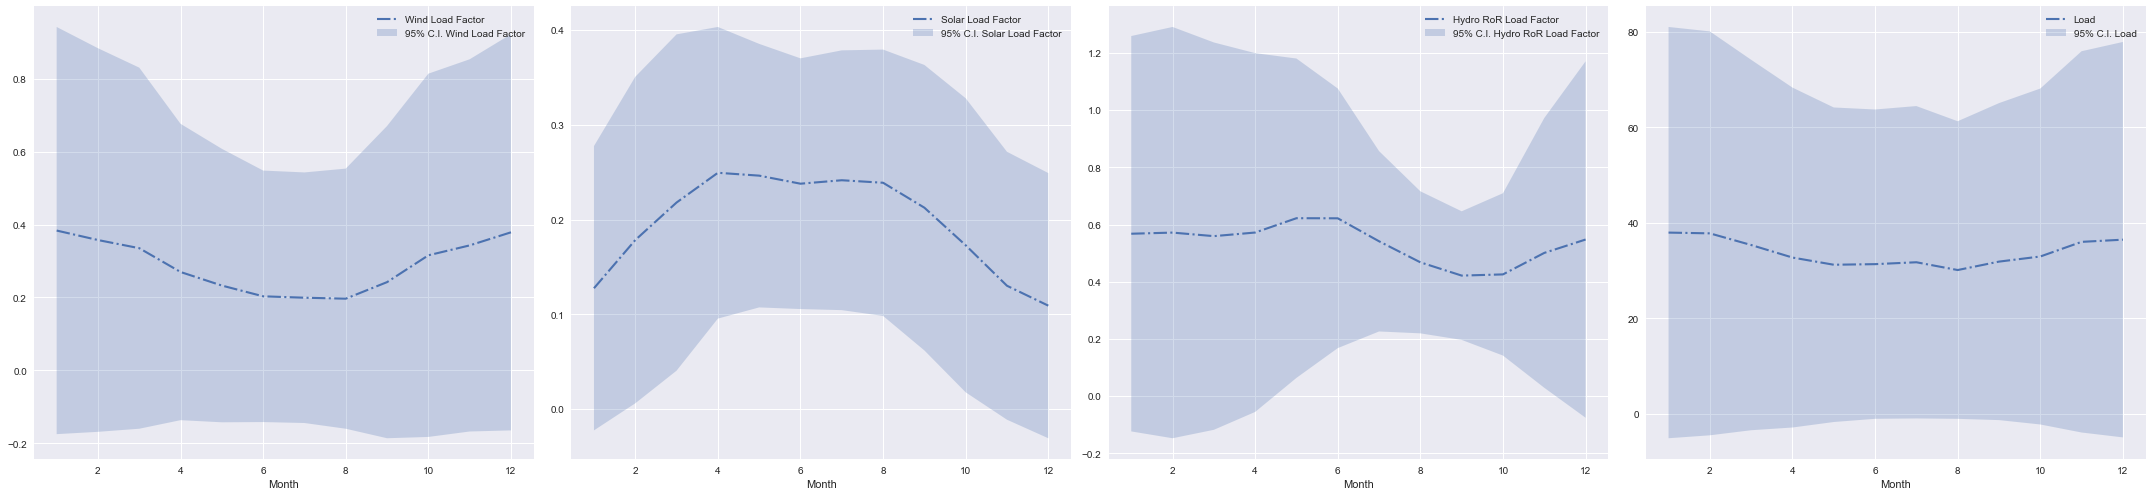

In [559]:
plot_bands(df, df.index.get_level_values(1).month, ['Wind Load Factor', 'Solar Load Factor', 'Hydro RoR Load Factor', 'Load'],
          'Month', '', os.path.join(path, 'EU-7', 'bands_energy_vars.png'))

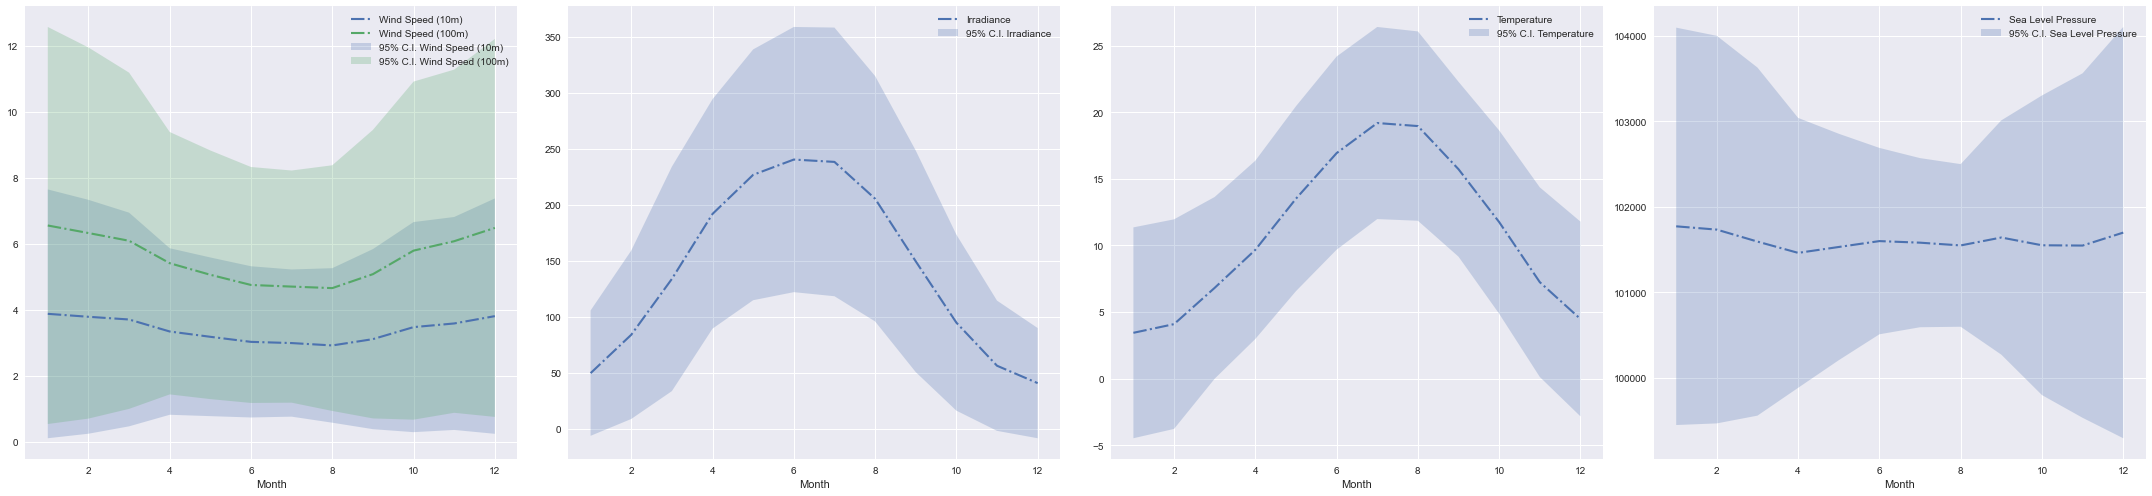

In [560]:
plot_bands(df, df.index.get_level_values(1).month, [['Wind Speed (10m)', 'Wind Speed (100m)'], 'Irradiance', 'Temperature', 'Sea Level Pressure'],
          'Month', '', os.path.join(path, 'EU-7', 'bands_weather_vars.png'))

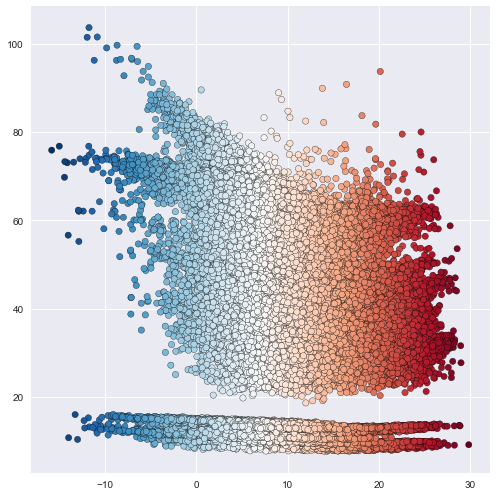

In [578]:
plot_scatter(df[df.index.get_level_values(1).map(pd.tseries.offsets.BDay().onOffset)], 'Temperature', 'Load',
             os.path.join(path, 'EU-7', 'temperature_vs_load_bdays.png'),
            c = df[df.index.get_level_values(1).map(pd.tseries.offsets.BDay().onOffset)]['Temperature'], cmap ='RdBu_r')

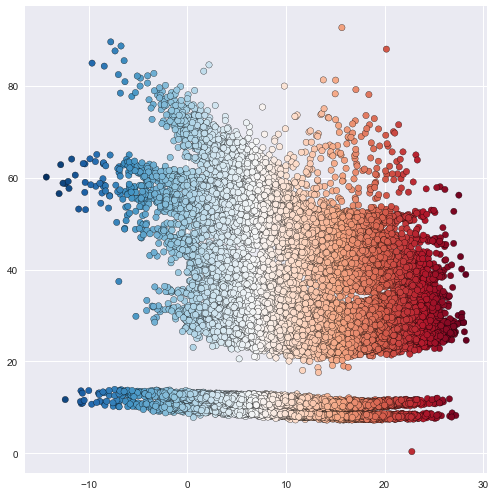

In [577]:
plot_scatter(df[[not elem for elem in df.index.get_level_values(1).map(pd.tseries.offsets.BDay().onOffset)]],
             'Temperature', 'Load', os.path.join(path, 'EU-7', 'temperature_vs_load_holidays.png'),
            c = df[[not elem for elem in df.index.get_level_values(1).map(pd.tseries.offsets.BDay().onOffset)]]['Temperature'], cmap ='RdBu_r')

## Country

In [580]:
shps = {"FR":"FRA", "UK":"GBR", "BE":"BEL", "NE":"NED", "IT":"ITA", "GE":"DEU", "ES":"ESP"}
path = "energy_imgs"
country = 'GE'
shp_cnt = shps[country]
model = "Bayesian-GMM"
try:
    os.makedirs(os.path.join(path, country, model))
except OSError as oserr:
    print(oserr)

In [581]:
country_df = df.xs(country, level =0).copy()
country_df.index = pd.to_datetime(country_df.index)
country_df.dropna(how='all', inplace = True, axis = 1)
country_df.dropna(how='all', inplace = True, axis = 0)
country_df

Load  Hydro Load Factor  Hydro Reservoir Obs  \
1979-01-01  55.2080                NaN                  NaN   
1979-01-02  62.0643                NaN                  NaN   
1979-01-03  63.7682                NaN                  NaN   
1979-01-04  64.2080                NaN                  NaN   
1979-01-05  62.0801                NaN                  NaN   
...             ...                ...                  ...   
2021-06-26  50.8413           0.139148              0.15028   
2021-06-27  46.0744           0.132093              0.14266   
2021-06-28  60.8310           0.131954              0.14251   
2021-06-29  62.1274           0.153259              0.16552   
2021-06-30  61.8908           0.147176              0.15895   

            Hydro RoR Load Factor  Hydro RoR Obs  Solar Photo Load Factor  \
1979-01-01                    NaN            NaN                 0.152666   
1979-01-02                    NaN            NaN                 0.156367   
1979-01-03                    NaN            NaN                 0.167611   
1979-01-04                    NaN            NaN                 0.166868   
1979-01-05                    NaN            NaN                 0.161469   
...                           ...            ...                      ...   
2021-06-26               0.608023        2.38880                 0.253686   
2021-06-27               0.609517        2.39467                 0.273457   
2021-06-28               0.658023        2.58524                 0.253231   
2021-06-29               0.654482        2.57133                 0.180045   
2021-06-30               0.606340        2.38219                 0.150164   

            Solar Photo Obs  Wind Offshore Load Factor  \
1979-01-01         6.897281                   0.543457   
1979-01-02         7.064517                   0.399096   
1979-01-03         7.572513                   0.444174   
1979-01-04         7.538918                   0.385852   
1979-01-05         7.295011                   0.141815   
...                     ...                        ...   
2021-06-26        11.461298                   0.005582   
2021-06-27        12.354503                   0.015796   
2021-06-28        11.440715                   0.049972   
2021-06-29         8.134271                   0.051437   
2021-06-30         6.784244                   0.127462   

            Wind Onshore Load Factor  Wind Onshore Obs  ...  Total Wind Obs  \
1979-01-01                  0.435693         22.850805  ...       22.850805   
1979-01-02                  0.463056         24.285908  ...       24.285908   
1979-01-03                  0.480440         25.197625  ...       25.197625   
1979-01-04                  0.275016         14.423779  ...       14.423779   
1979-01-05                  0.138530          7.265492  ...        7.265492   
...                              ...               ...  ...             ...   
2021-06-26                  0.026658          1.398106  ...        1.398106   
2021-06-27                  0.060488          3.172393  ...        3.172393   
2021-06-28                  0.079076          4.147291  ...        4.147291   
2021-06-29                  0.095716          5.020029  ...        5.020029   
2021-06-30                  0.241366         12.658947  ...       12.658947   

            Total Wind Capacity  Wind Load Factor  Solar Load Factor  \
1979-01-01               52.447          0.435693           0.152666   
1979-01-02               52.447          0.463056           0.156367   
1979-01-03               52.447          0.480440           0.167611   
1979-01-04               52.447          0.275016           0.166868   
1979-01-05               52.447          0.138530           0.161469   
...                         ...               ...                ...   
2021-06-26               52.447          0.026658           0.253686   
2021-06-27               52.447          0.060488           0.273457   
2021-06-28               52.447        

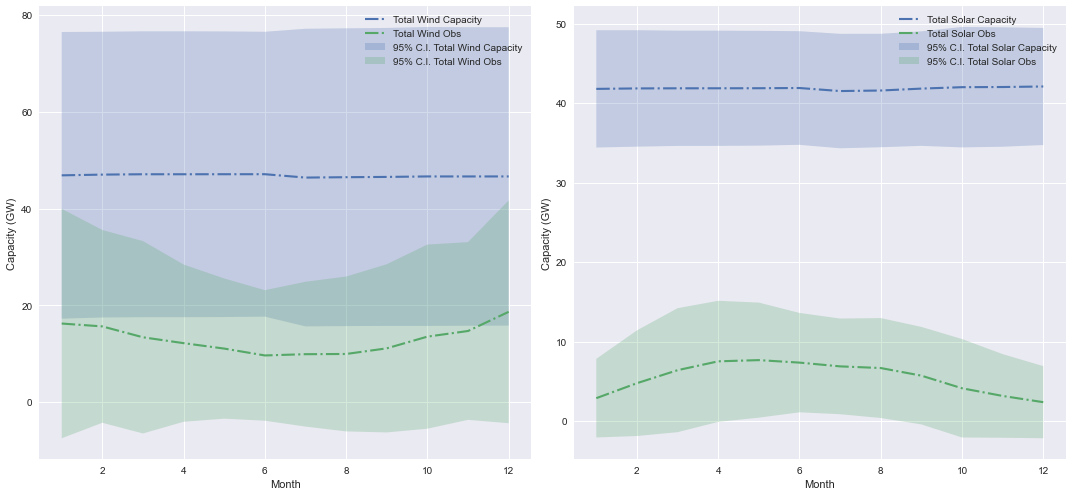

In [592]:
plot_bands(country_df[country_df.index.year >= 2011], country_df[country_df.index.year >= 2011].index.month,
           [['Total Wind Capacity', 'Total Wind Obs'], ['Total Solar Capacity', 'Total Solar Obs']],
           'Month', 'Capacity (GW)',os.path.join(path, country, 'monthly_trend_obs_capacity.png'))

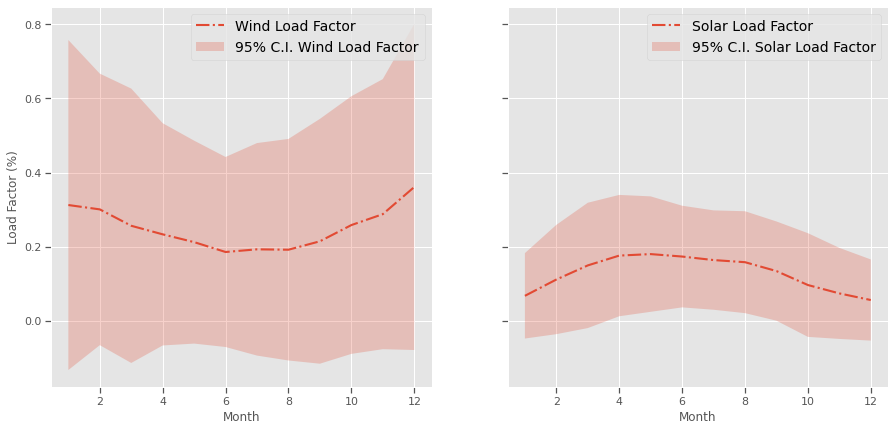

In [594]:
plot_load_factors(country_df[country_df.index.year >= 2011], ['Wind Load Factor', 'Solar Load Factor'],
                  os.path.join(path, country, 'monthly_trend_loadfactor.png'))

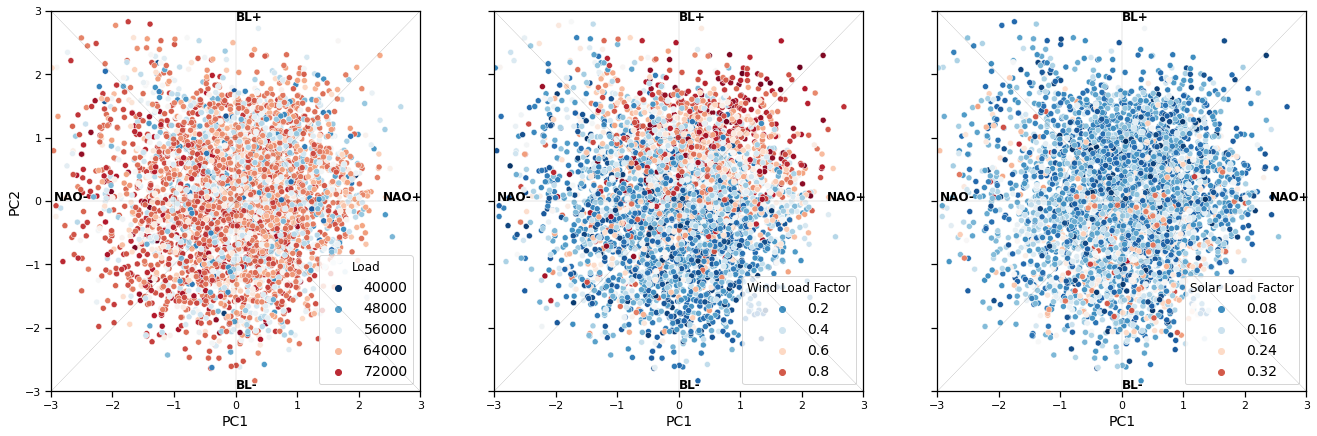

In [269]:
plot_3Dpcs(country_df, pcs, ['Load','Wind Load Factor', 'Solar Load Factor'],
           os.path.join(path, DATA_TYPE, country, 'scatter_measure_pcs.png'))

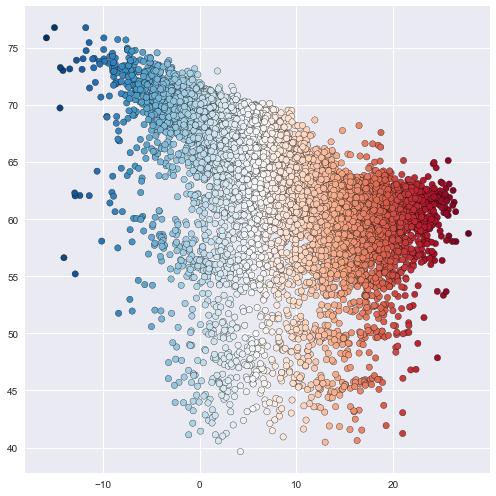

In [596]:
plot_scatter(country_df[country_df.index.map(pd.tseries.offsets.BDay().onOffset)],
             'Temperature', 'Load',
             os.path.join(path, country, 'temperature_vs_load_bdays.png'),
             c = country_df[country_df.index.map(pd.tseries.offsets.BDay().onOffset)]['Temperature'],
             cmap ='RdBu_r')

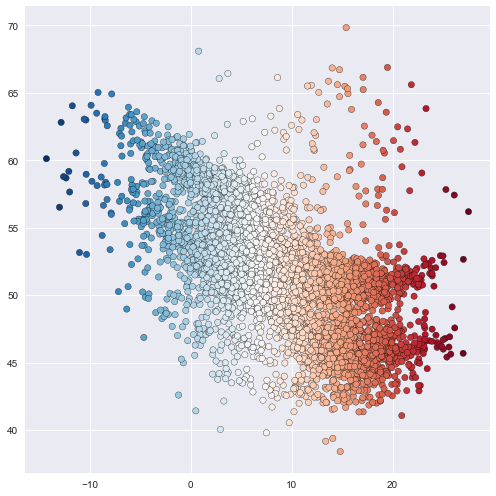

In [598]:
plot_scatter(country_df[[not elem for elem in country_df.index.map(pd.tseries.offsets.BDay().onOffset)]],
             'Temperature', 'Load',
             os.path.join(path, country, 'temperature_vs_load_holidays.png'),
             c = country_df[[not elem for elem in country_df.index.map(pd.tseries.offsets.BDay().onOffset)]]['Temperature'],
             cmap ='RdBu_r')

#### Regimes

In [270]:
country_df = filter_by_preds(country_df, predictions, model)

NAO+    1389
SB       951
AR       878
NAO-     632
Name: Regime, dtype: int64


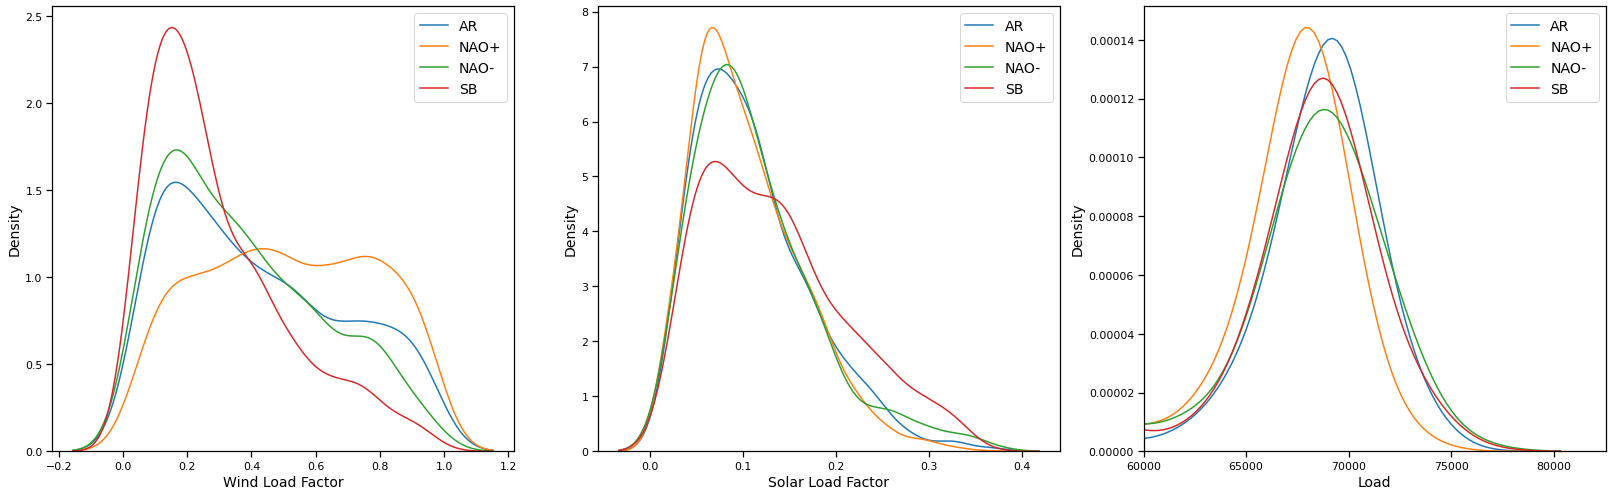

In [296]:
plot_distribution_by_regime(country_df[country_df.index.dayofweek<5], ['Wind Load Factor', 'Solar Load Factor','Load'],#,'Hydro Load Factor'],
                 predictions, model, os.path.join(path, DATA_TYPE, country, model, 'distributions_load_factors_regimes.png'))

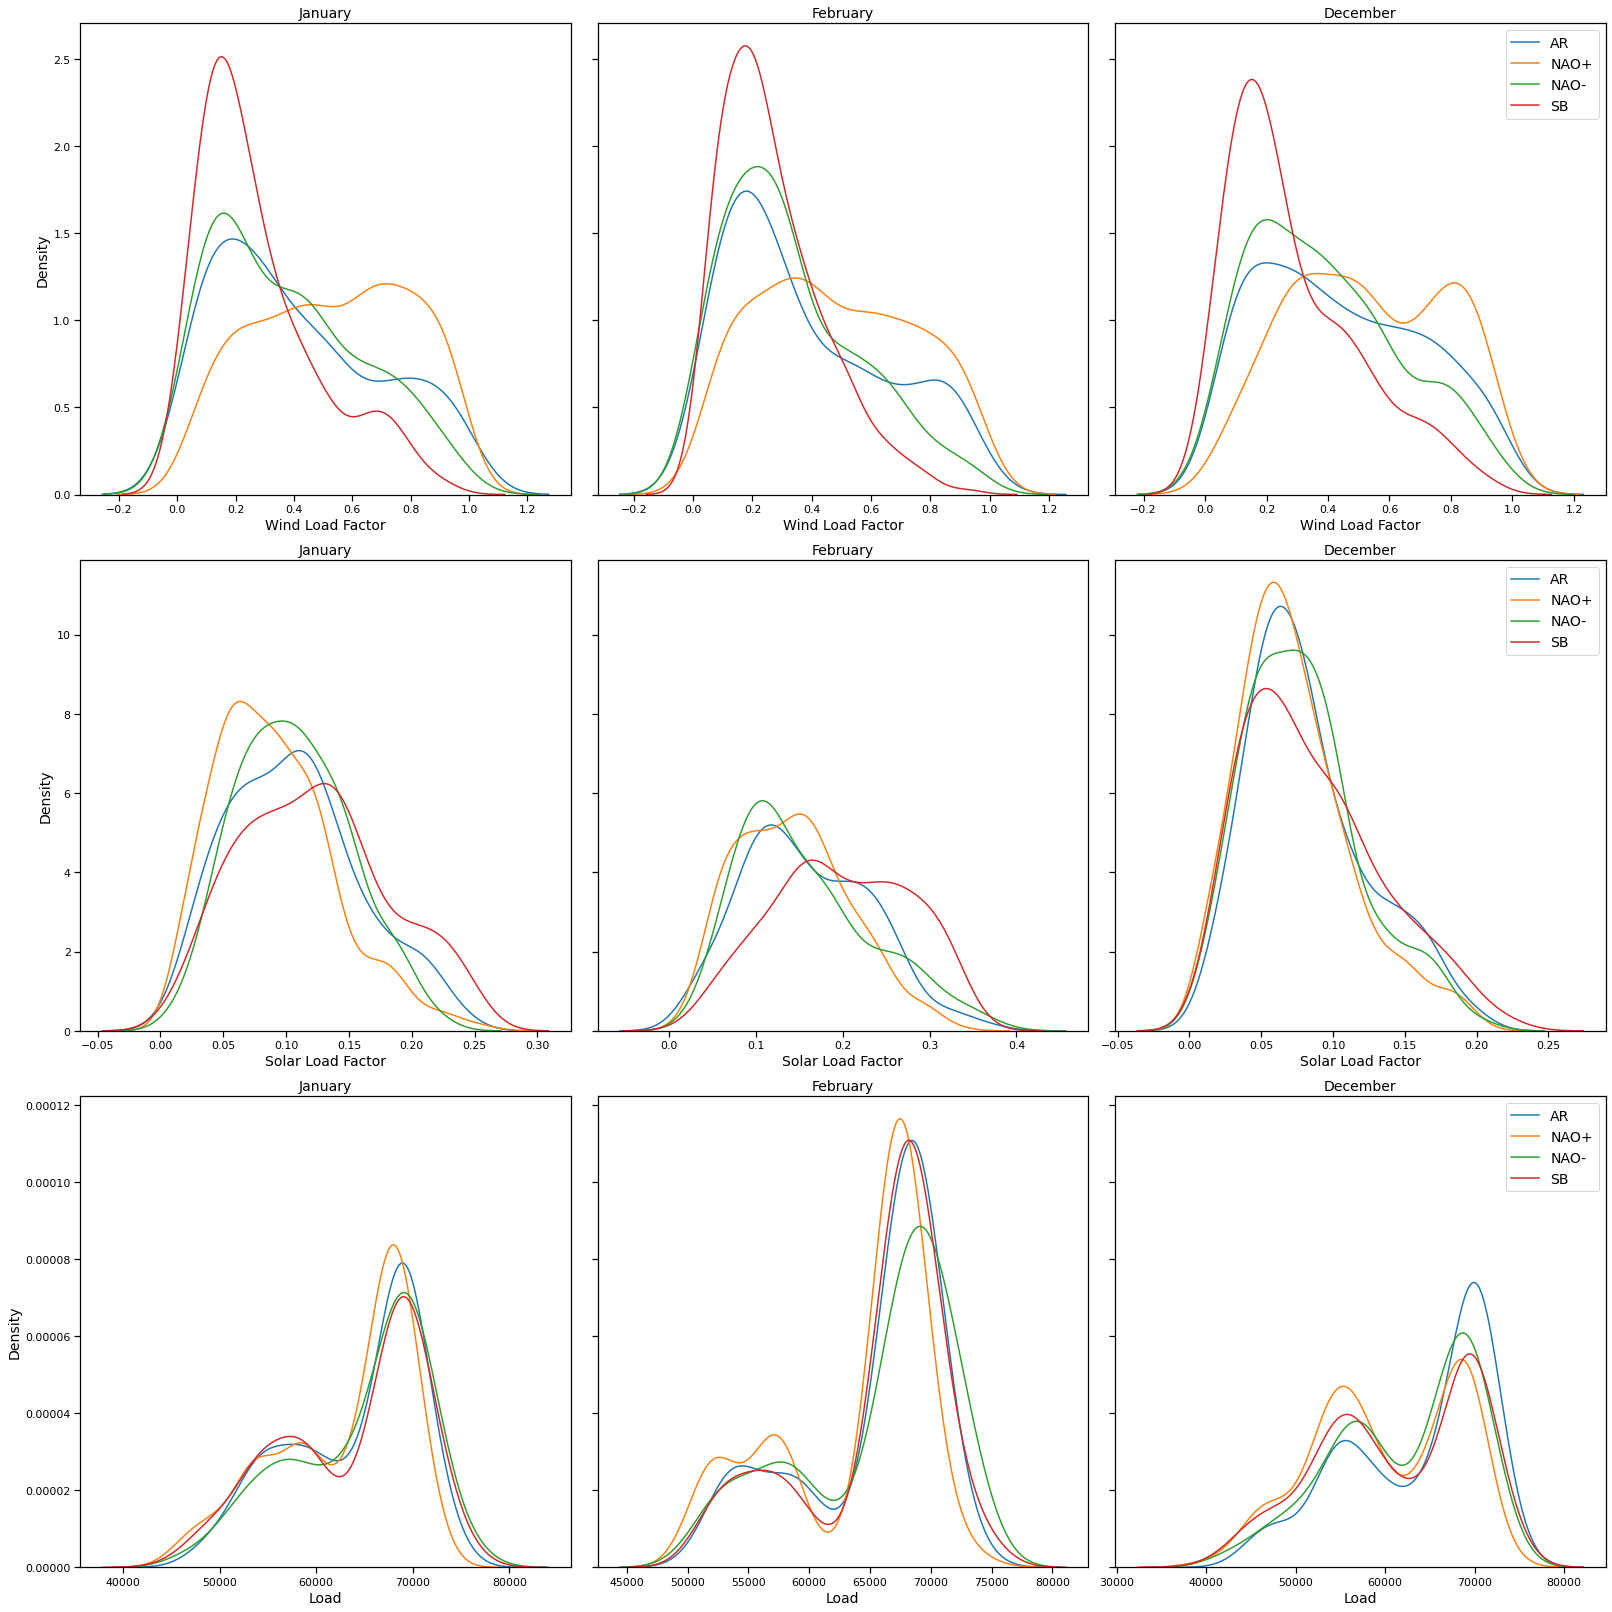

In [272]:
plot_distribution_by_regime_monthly(country_df, ['Wind Load Factor', 'Solar Load Factor','Load'],#, 'Hydro Load Factor'],
                 os.path.join(path, DATA_TYPE, country, model, 'distributions_monthly_load_factors_regimes.png'))

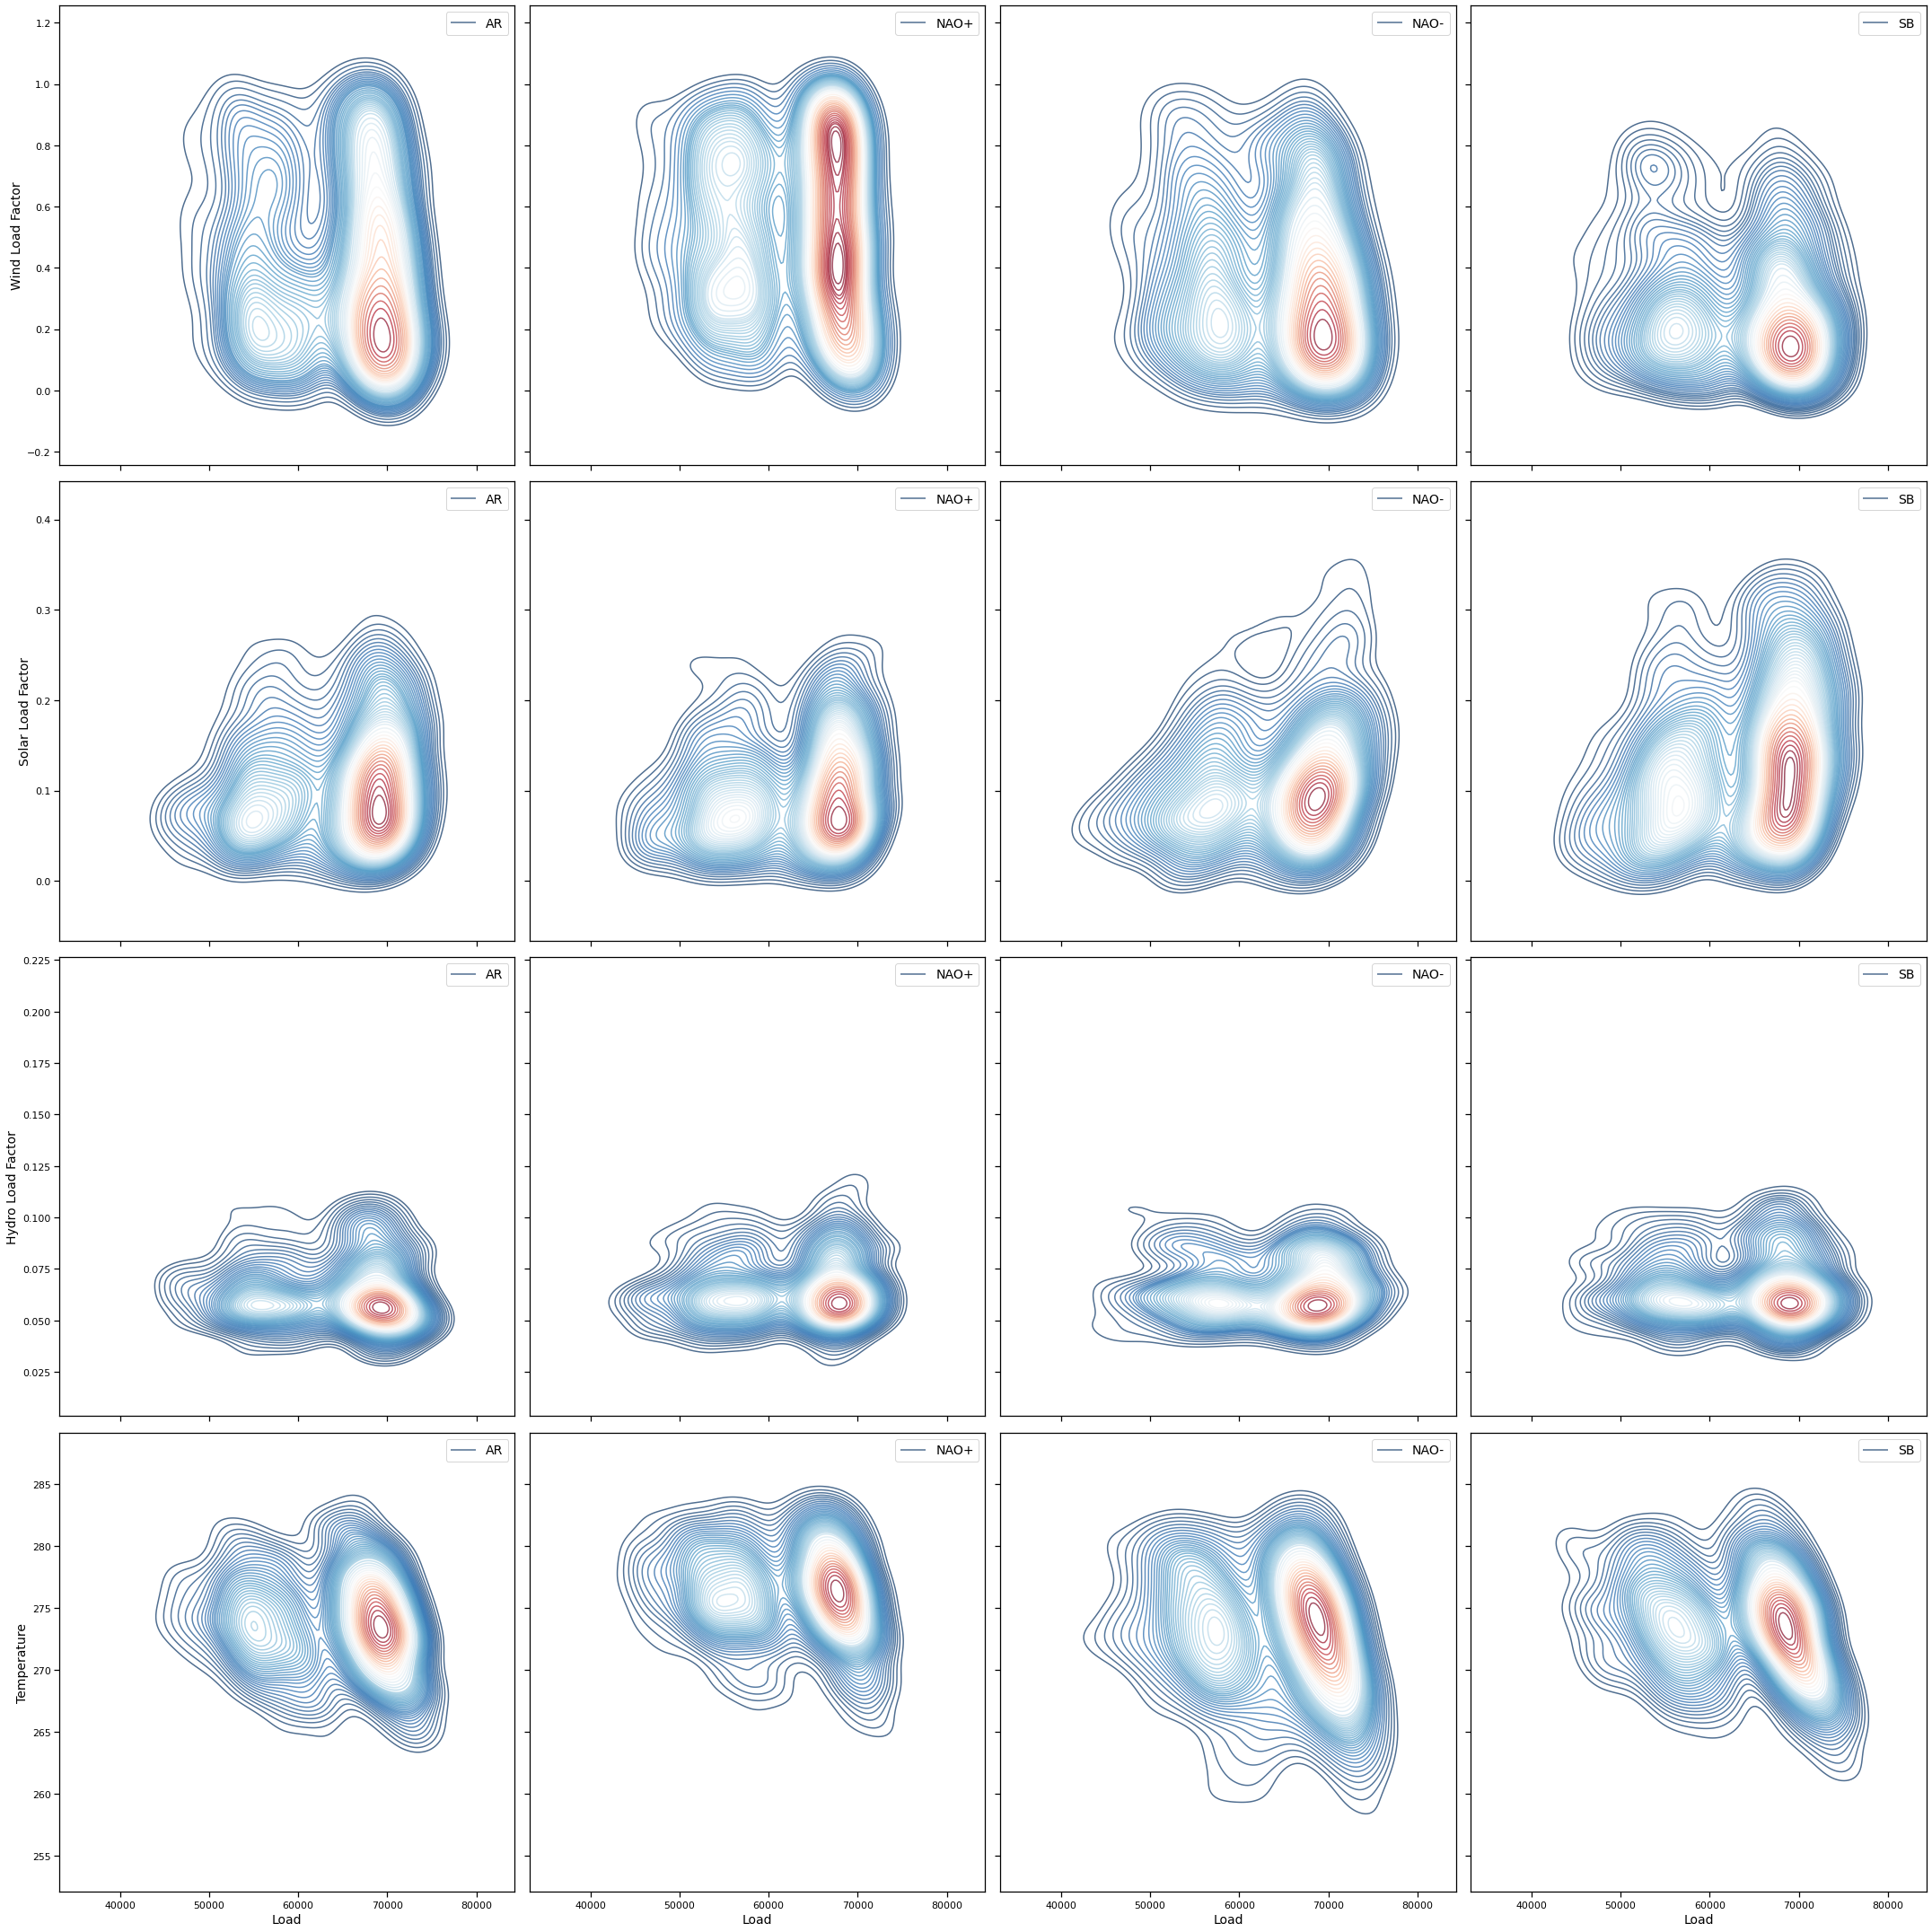

In [298]:
plot_densities_vs_variable(country_df, 'Load', ['Wind Load Factor', 'Solar Load Factor', 'Hydro Load Factor','Temperature'],
                          os.path.join(path, DATA_TYPE, country, model, 'densities_load_factors_price_regimes.png'))

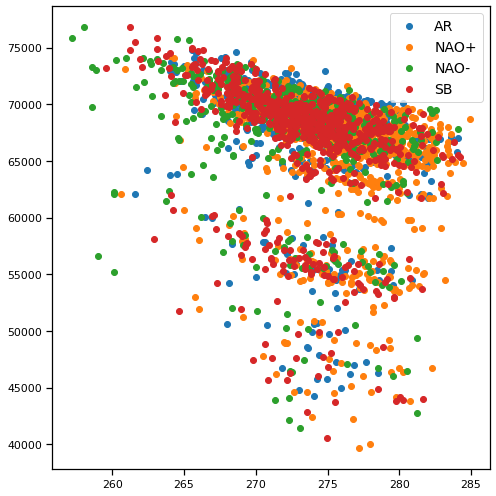

In [303]:
plot_scatter_by_regime(country_df[country_df.index.weekday < 5], 'Temperature', 'Load')

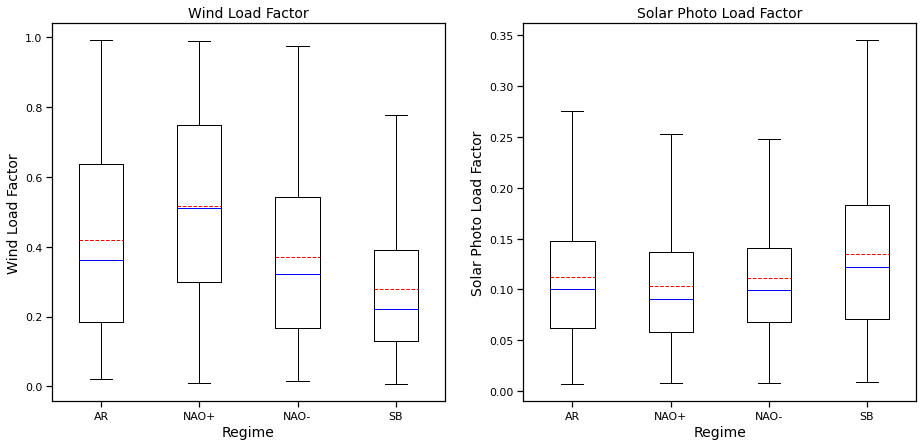

In [185]:
boxplot(country_df, ['Regime'], ['Wind Load Factor', 'Solar Photo Load Factor'],
        os.path.join(path, DATA_TYPE, country, model, 'boxplots.png'))

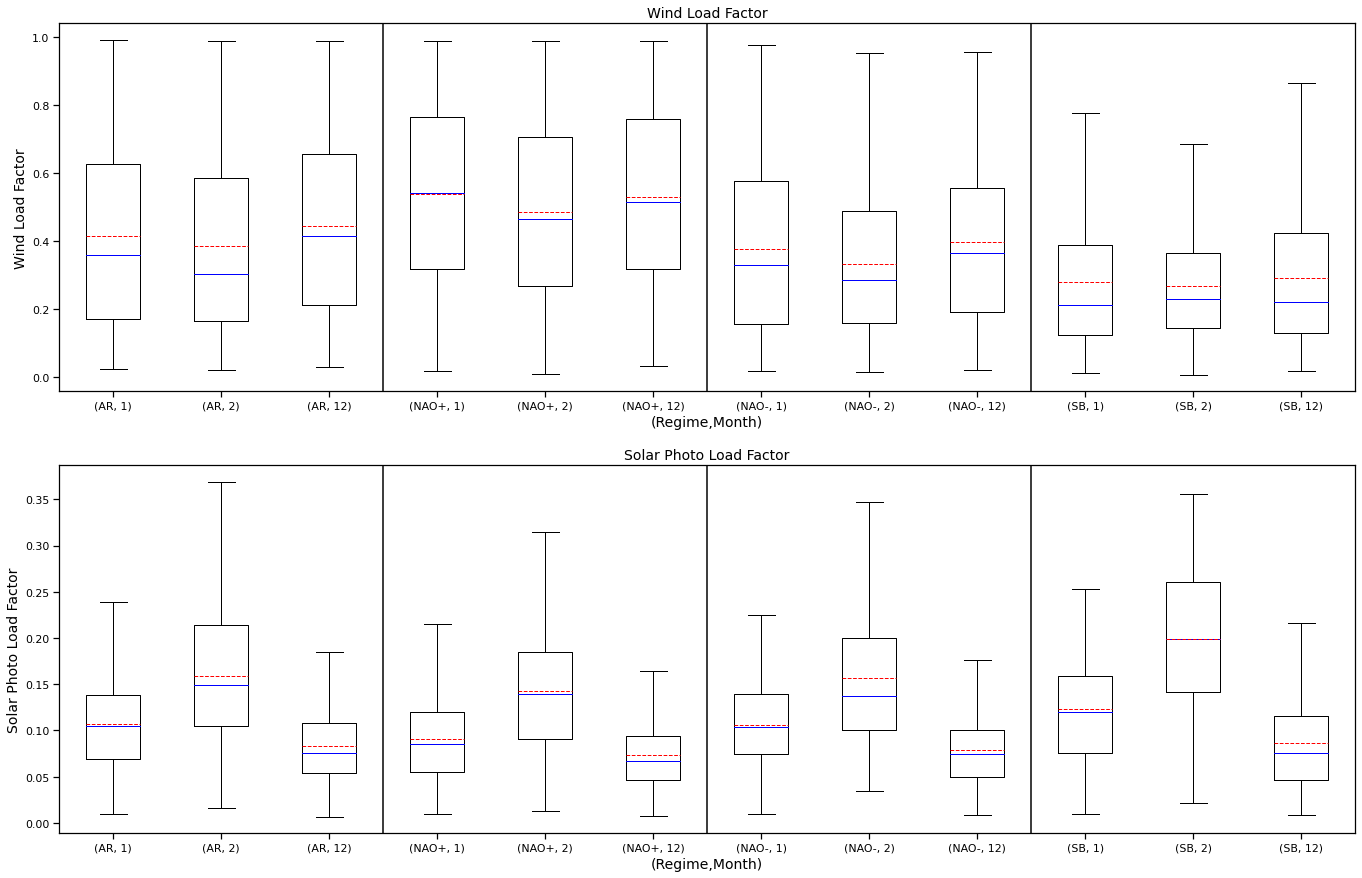

In [186]:
boxplot_monthly(country_df, ['Regime', 'Month'], ['Wind Load Factor', 'Solar Photo Load Factor'],
                os.path.join(path, DATA_TYPE, country, model, 'boxplots_monthly.png'))

In [187]:
monthly_stats = country_df.groupby([country_df.index.month, 'Regime']).mean()
monthly_stats

Load  Hydro Load Factor  Hydro Reservoir Obs  \
   Regime                                                         
1  AR      63997.707600           0.064551            69.714959   
   NAO+    62849.966845           0.066498            71.817641   
   NAO-    64576.229703           0.064192            69.326825   
   SB      63689.114375           0.065648            70.900222   
2  AR      65242.494862           0.068751            74.250968   
   NAO+    63724.153813           0.067380            72.770601   
   NAO-    65587.869271           0.070077            75.682872   
   SB      65466.076849           0.067798            73.221589   
12 AR      63687.899200           0.060312            65.137307   
   NAO+    60071.206504           0.063737            68.835935   
   NAO-    62179.714286           0.063471            68.548151   
   SB      61359.890625           0.064697            69.872531   

           Hydro RoR Load Factor  Hydro RoR Obs  Solar Photo Load Factor  \
   Regime                                                                  
1  AR                   0.373153    1466.043293                 0.107098   
   NAO+                 0.389441    1530.035735                 0.090497   
   NAO-                 0.382541    1502.925344                 0.106214   
   SB                   0.373860    1468.821424                 0.122835   
2  AR                   0.364883    1433.551734                 0.158602   
   NAO+                 0.381094    1497.242650                 0.142434   
   NAO-                 0.370958    1457.421489                 0.156944   
   SB                   0.374878    1472.819503                 0.198383   
12 AR                   0.382773    1503.839467                 0.083276   
   NAO+                 0.387595    1522.784824                 0.073879   
   NAO-                 0.383620    1507.164412                 0.079217   
   SB                   0.383231    1505.638438                 0.086006   

           Solar Photo Obs  Wind Offshore Load Factor  \
   Regime                                               
1  AR          4838.602398                   0.376417   
   NAO+        4088.572850                   0.445595   
   NAO-        4798.624551                   0.316323   
   SB          5549.564544                   0.286757   
2  AR          7165.485958                   0.354114   
   NAO+        6435.008894                   0.420204   
   NAO-        7090.581848                   0.301943   
   SB          8962.722983                   0.281992   
12 AR          3762.343138                   0.398697   
   NAO+        3337.791575                   0.438267   
   NAO-        3578.959548                   0.309574   
   SB          3885.674437                   0.303173   

           Wind Onshore Load Factor  Wind Onshore Obs  ...  Irradiance  \
   Regime                                              ...               
1  AR                      0.415739      21804.266697  ...   36.925423   
   NAO+                    0.537296      28179.579536  ...   32.149027   
   NAO-                    0.377551      19801.439603  ...   35.460148   
   SB                      0.278792      14621.825215  ...   39.309785   
2  AR                      0.384198      20150.011258  ...   67.703489   
   NAO+                    0.484352      25402.813416  ...   61.640891   
   NAO-                    0.331059      17363.035811  ...   67.103401   
   SB                      0.268290      14071.000179  ...   78.597551   
12 AR                      0.444979      23337.824707  ...   27.591277   
   NAO+                    0.530552      27825.844181  ...   25.048071   
   NAO-                    0.396032      20770.682374  ...   26.252643   
   SB                      0.290517      15236.718967  ...   27.647827   

           Sea Level Pressure  Precipitation  Wind Speed (10m)  \
   Regime                                                        
1  AR           101981.885607       0.002124   

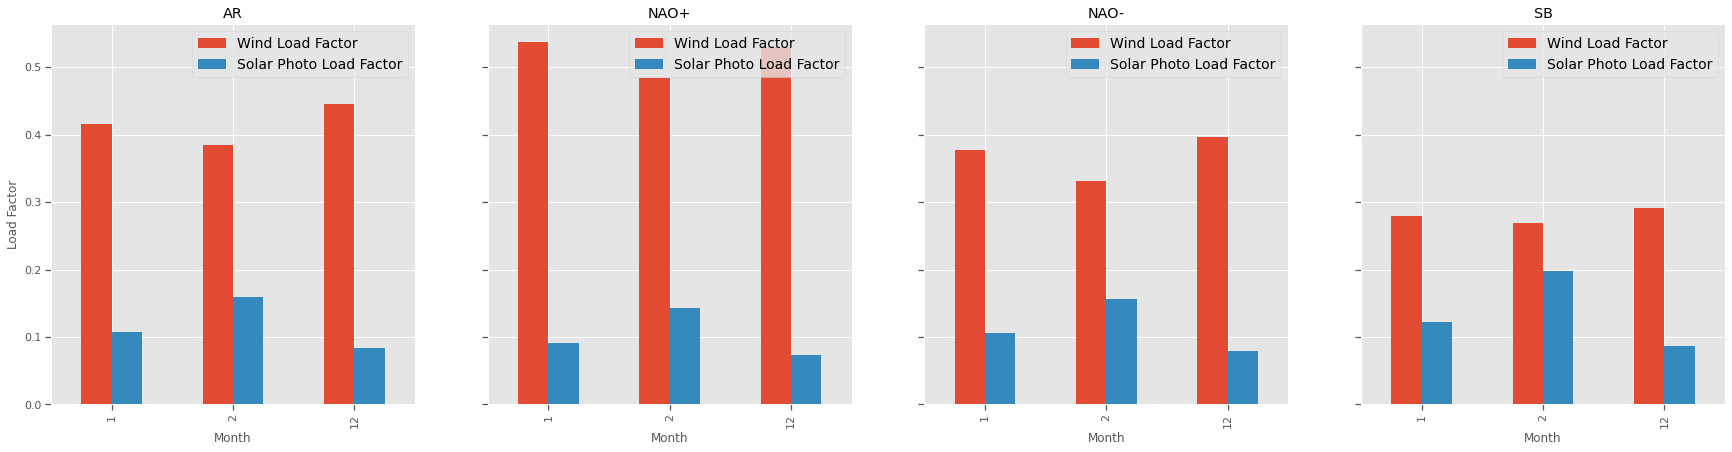

In [188]:
plot_bars(monthly_stats, ['Wind Load Factor', 'Solar Photo Load Factor'],
          os.path.join(path, DATA_TYPE, country, model, 'monthly_trend_loadfactor_regimes.png'))

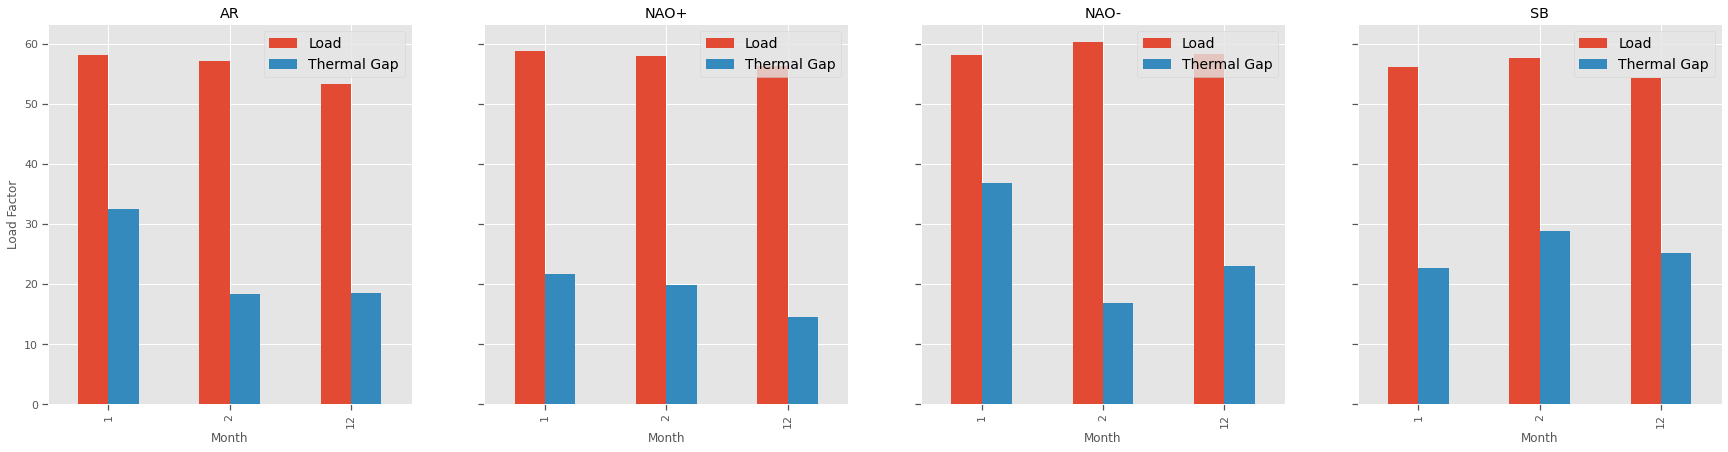

In [135]:
monthly_stats["Thermal Gap"] = monthly_stats["Load"] - sum(monthly_stats[col] for col in monthly_stats.columns if 'Obs' in col)
plot_bars(monthly_stats, ['Load', 'Thermal Gap'],
         os.path.join(path, country, model, 'monthly_trend_thermalgap_regimes.png'))

### Anomaly

In [50]:
anomaly = df[['Wind Load Factor', 'Solar Load Factor']] - \
df[np.logical_and(df.index.get_level_values(1).year >= 2015, np.isin(df.index.get_level_values(1).month, [1,2,12]))][['Wind Load Factor', 'Solar Load Factor']].groupby('Country').mean()
anomaly

Wind Load Factor  Solar Load Factor
Country Start                                          
ES      2011-01-01         -0.200301                NaN
        2011-01-02          0.062609                NaN
        2011-01-03          0.173247                NaN
        2011-01-04          0.026165                NaN
        2011-01-05         -0.126708                NaN
...                              ...                ...
UK      2020-12-27          0.068033          -0.015008
        2020-12-28         -0.259215          -0.047819
        2020-12-29         -0.179570          -0.045334
        2020-12-30         -0.200667          -0.037720
        2020-12-31         -0.203302          -0.028514

[18611 rows x 2 columns]

In [70]:
anomaly_country_df = anomaly.xs(country, level = 0)

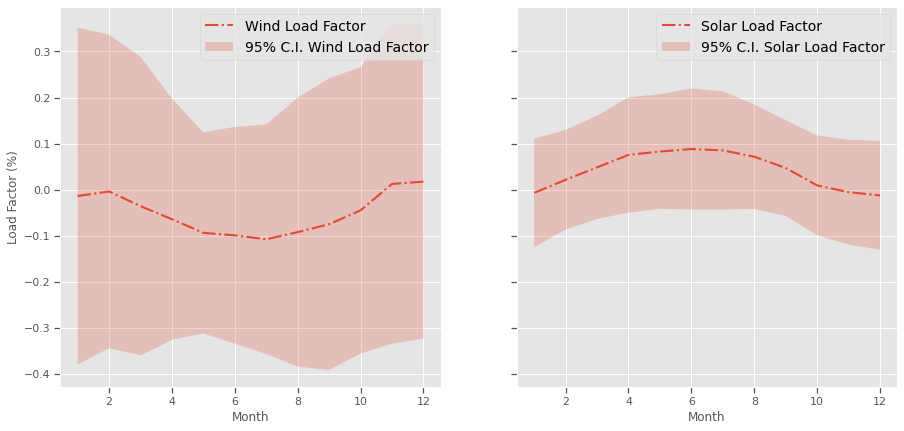

In [71]:
plot_load_factors(anomaly_country_df, ['Wind Load Factor', 'Solar Load Factor'],
                  os.path.join(path, country,'monthly_trend_anomaly_load_factors.png'))

In [74]:
anomaly_country_df = filter_by_preds(anomaly_country_df, predictions, model)

NAO-    328
SB      175
NAO+    153
AR       66
Name: Regime, dtype: int64

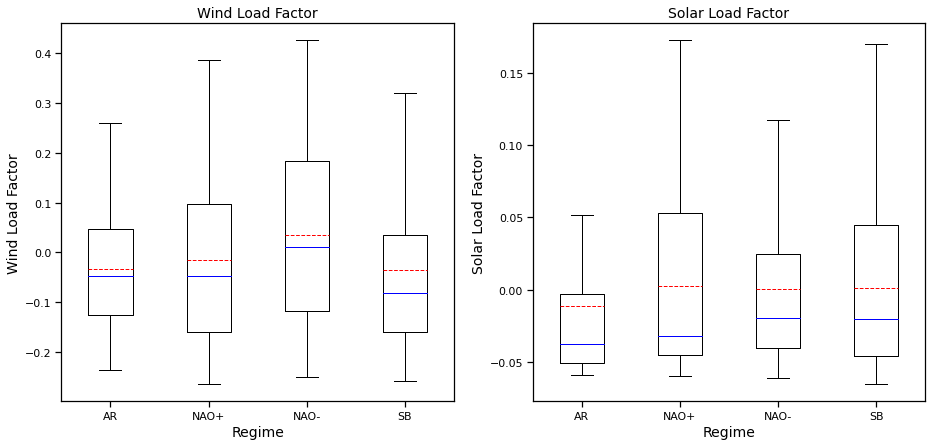

In [81]:
boxplot(anomaly_country_df, ['Regime'], ['Wind Load Factor', 'Solar Load Factor'],
        os.path.join(path, country, model, 'boxplots_anomaly.png'))

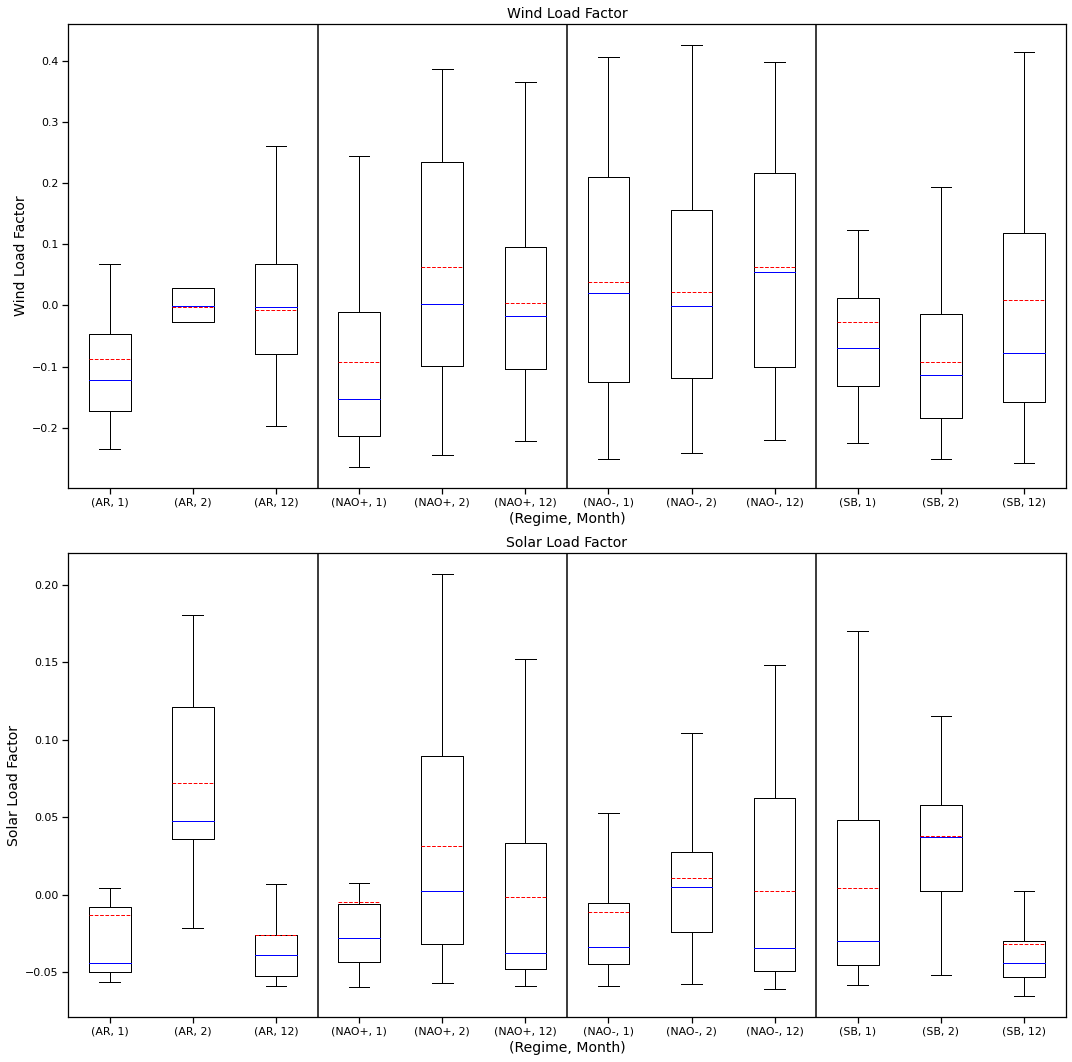

In [84]:
boxplot_monthly(anomaly_country_df, ['Regime', 'Month'], ['Wind Load Factor', 'Solar Load Factor'],
              os.path.join(path, country, model, 'boxplots_monthly_anomaly.png'))

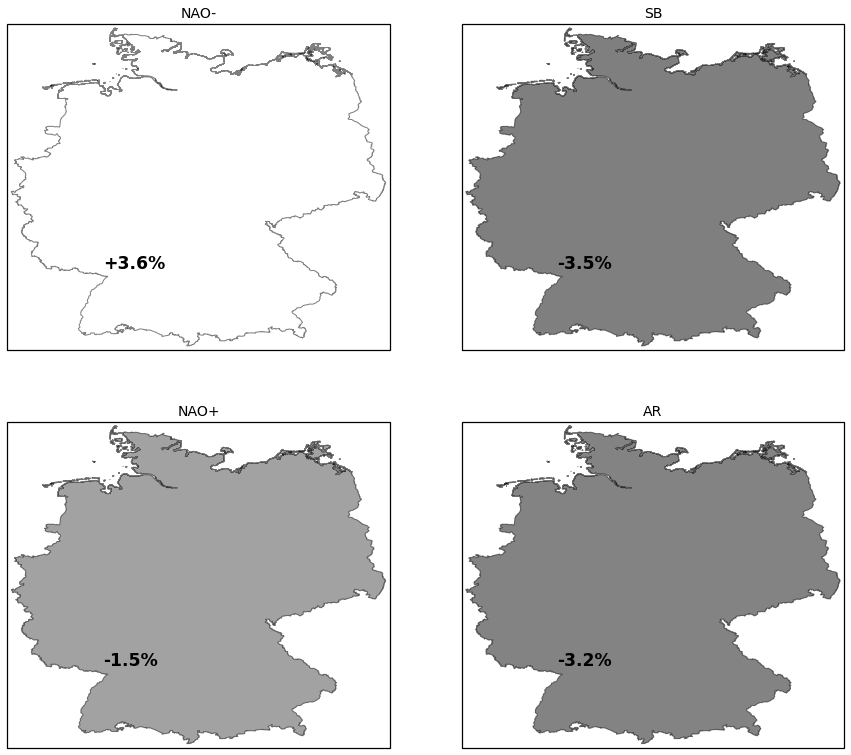

In [85]:
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(15,15))
axs = AxesGrid(fig, 111, axes_class=axes_class,nrows_ncols=(2, 2),axes_pad=1, label_mode='')
fname = 'P:/CH/Weather Data/SHP_FILES/gadm36_{}_shp/gadm36_{}_0.shp'.format(shp_cnt, shp_cnt)
shapes = list(shpreader.Reader(fname).geometries())
mm = anomaly_country_df.groupby('Regime').mean() * 100
colors = (mm - mm.min()) / (mm.max() - mm.min()) 
for ax, regime in (zip(axs, anomaly_country_df['Regime'].unique())):
    
    ax.add_geometries(shapes, ccrs.PlateCarree(),
                      edgecolor='k', facecolor= str(colors.loc[regime, 'Wind Load Factor']), alpha=0.5)
    x0, y0, x1, y1 = shapes[0].bounds
    if mm.loc[regime, 'Wind Load Factor'] > 0:
        text = "+"
    else:
        text = ""
    text += str(round(mm.loc[regime, 'Wind Load Factor'],1)) + "%"
    ax.text(.25, .25, text,
            fontsize = 'xx-large', fontweight = 'black', transform = ax.transAxes)
    ax.set_extent([x0-0.1,x1+0.1,y0-0.1,y1+0.1])
    ax.set_title(regime)
plt.show()

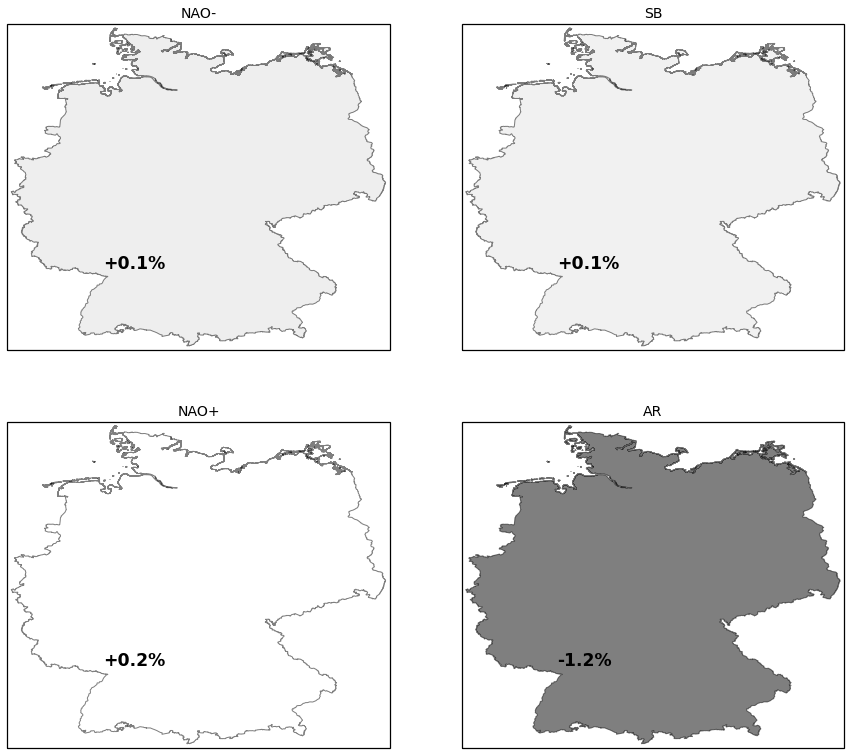

In [86]:
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(15,15))
axs = AxesGrid(fig, 111, axes_class=axes_class,nrows_ncols=(2, 2),axes_pad=1, label_mode='')
fname = 'P:/CH/Weather Data/SHP_FILES/gadm36_{}_shp/gadm36_{}_0.shp'.format(shp_cnt, shp_cnt)
shapes = list(shpreader.Reader(fname).geometries())
mm = anomaly_country_df.groupby('Regime').mean() * 100
colors = (mm - mm.min()) / (mm.max() - mm.min()) 
for ax, regime in (zip(axs, anomaly_country_df['Regime'].unique())):
    
    ax.add_geometries(shapes, ccrs.PlateCarree(),
                      edgecolor='k', facecolor= str(colors.loc[regime, 'Solar Load Factor']), alpha=0.5)
    x0, y0, x1, y1 = shapes[0].bounds
    if mm.loc[regime, 'Solar Load Factor'] > 0:
        text = "+"
    else:
        text = ""
    text += str(round(mm.loc[regime, 'Solar Load Factor'],1)) + "%"
    ax.text(.25, .25, text,
            fontsize = 'xx-large', fontweight = 'black', transform = ax.transAxes)
    ax.set_extent([x0-0.1,x1+0.1,y0-0.1,y1+0.1])
    ax.set_title(regime)
plt.show()

# Labeling

## ECMWF

In [3]:
path = 'W:/UK/Research/Private/WEATHER/STAGE_ABALDO/dataset/Weather_Regime_ECMWF'
df = pd.DataFrame(columns = ['Step', 'NAO+', 'SB', 'NAO-', 'AR'])
for file in os.listdir(path):
    with open(path+'/'+file, "r") as f:
        next(f)
        date = next(f).strip()
        year,month,day = date[:4], date[4:6], date[6:8]
        date = "-".join([year, month, day])
        
    temp_df = pd.read_csv(path+'/'+file, skiprows=[0,1], header = 0, index_col = False,sep =':', usecols = range(0,6))
    temp_df.columns = names =  ['Step', 'NAO+', 'SB', 'NAO-', 'AR', 'Unknown']
    temp_df['Step'] //= 24
    temp_df.index = [date]*len(temp_df)
    temp_df.fillna(value = 0, inplace = True)
    
    def get_len(x):
        if isinstance(x, str):
            x = len(x.strip().split(","))-1
        return x
    
    temp_df = temp_df.apply(lambda serie:  serie.apply(lambda x: get_len(x)))
    df = df.append(temp_df)
df.index = pd.to_datetime(df.index)
df.reset_index(inplace = True)
df.rename(columns = {"index":"Actual Date"}, inplace = True)
df['Forecast Date'] = df.apply(lambda x: x['Actual Date'] + timedelta(days = x['Step']), axis =1)
df.set_index(['Actual Date', 'Forecast Date', 'Step'], inplace = True)
for col in df.columns:
    df[col] = pd.to_numeric(df[col])

df.loc[:,["NAO+", "SB", "AR", "NAO-", "Unknown"]] = df.loc[:,["NAO+", "SB", "AR", "NAO-", "Unknown"]].div(df.sum(axis=1), axis = 0)
df.dropna(how='any', inplace = True)

In [4]:
idx = df.reset_index(level=0, drop=True).reset_index(level=1).groupby(level = 0)['Step'].min().\
reset_index().set_index(['Forecast Date', 'Step']).index
df_unique = df.reset_index(level=0, drop=True).loc[pd.IndexSlice[idx]]
df_unique.to_csv('W:/UK/Research/Private/WEATHER/STAGE_ABALDO/dataset/targets_unique.csv')

In [37]:
scipy.stats.gaussian_kde([1,2,3,4,5,6,7,8,9,1,2,3,4,5,6,7,3,4,5,7,8]).resample(10)

array([[6.43576519, 1.06843064, 4.96542923, 0.20718257, 2.03854057,
        5.91094291, 8.80695804, 2.35031041, 5.44437453, 7.42524943]])

In [86]:
df.to_csv('W:/UK/Research/Private/WEATHER/STAGE_ABALDO/dataset/targets.csv')

## MeteoFrance

In [6]:
import pandas as pd
from datetime import datetime
import os
import itertools

In [50]:
path = 'W:/UK/Research/Private/WEATHER/STAGE_ABALDO/dataset/MeteoFrance'
dist_df, corr_df = [], []
for file in os.listdir(path):
    if any(col in file for col in ['EQM', 'COREL']):
        temp_df = pd.read_csv(os.path.join(path, file), sep = r'\s+',
                              index_col = None)
        col_names = {"H_ZO": ("Winter","NAO+"), "H_AR": ("Winter","AR"),
                                  "H_EA": ("Winter","SB"), "H_AL":("Winter","NAO-"),
                                  "E_GA": ("Summer", "NAO-"), "E_AL":("Summer","AL"),
                                  "E_EA": ("Summer", "SB"), "E_ZO": ("Summer", "Zonal")}
        temp_df = temp_df[col_names.keys()]
        temp_df.dropna(how='all', axis=1, inplace = True)
        temp_df.rename(columns = col_names, inplace = True)
        temp_df.index = temp_df.index.map(lambda x: datetime.strptime(str(x), "%Y%m%d"))
        if 'EQM' in file:
            dist_df.append(temp_df)
        else:
            corr_df.append(temp_df)

In [51]:
dist_df, corr_df = pd.concat(dist_df), pd.concat(corr_df)

In [52]:
dist_df.columns = pd.MultiIndex.from_tuples(dist_df.columns)
dist_df = pd.concat([dist_df], axis = 1, keys = ['Distance']).swaplevel(0,1,1)
corr_df.columns = pd.MultiIndex.from_tuples(corr_df.columns)
corr_df = pd.concat([corr_df], axis = 1, keys = ['Correlation']).swaplevel(0,1,1)

In [57]:
df = pd.concat([dist_df, corr_df], axis =1)
df

Winter                             Summer                    \
           Distance                           Distance                     
               NAO+      AR       SB     NAO-     NAO-       AL       SB   
1981-01-01  1022.54  617.35  1167.86  1242.46   909.77  1025.86   967.75   
1981-01-02   955.04  550.53  1091.45  1120.10   767.34   888.66   871.51   
1981-01-03  1122.83  752.04  1238.06  1075.89   851.78   999.67  1029.10   
1981-01-04  1165.05  707.21  1165.97  1030.33   800.49   966.80   934.25   
1981-01-05  1062.74  536.47   925.49   943.92   673.35   839.54   715.43   
...             ...     ...      ...      ...      ...      ...      ...   
2021-02-24   625.51  971.76   716.12  1070.76   800.04   643.70   684.70   
2021-02-25   551.35  800.39   643.65  1011.53   725.20   623.33   600.98   
2021-02-26   654.12  780.01   618.64  1077.50   750.02   670.11   564.62   
2021-02-27   848.26  840.46   588.85  1186.37   878.79   830.89   635.61   
2021-02-28   852.76  756.83   481.37  1032.75   739.89   752.90   531.05   

                        Winter                                 Summer  \
                   Correlation                            Correlation   
             Zonal        NAO+       AR       SB     NAO-        NAO-   
1981-01-01  879.74     0.06981  0.88002 -0.55819 -0.25876     0.22323   
1981-01-02  793.62     0.03820  0.85191 -0.64856 -0.12654     0.36456   
1981-01-03  975.91    -0.10591  0.70722 -0.75132  0.22665     0.61209   
1981-01-04  925.39    -0.30556  0.74316 -0.56196  0.26410     0.58081   
1981-01-05  755.12    -0.47279  0.78230 -0.25805  0.16462     0.42133   
...            ...         ...      ...      ...      ...         ...   
2021-02-24  655.58     0.47780 -0.41908  0.28218 -0.46275    -0.56243   
2021-02-25  562.24     0.46004 -0.18354  0.19358 -0.54470    -0.52419   
2021-02-26  566.19     0.30503 -0.03433  0.33498 -0.60035    -0.62089   
2021-02-27  704.37     0.03863  0.04154  0.63937 -0.61027    -0.64274   
2021-02-28  645.49    -0.21061  0.04867  0.68278 -0.37100    -0.38690   

                                       
                                       
                 AL       SB    Zonal  
1981-01-01 -0.53080 -0.19220  0.43076  
1981-01-02 -0.33873 -0.38404  0.28376  
1981-01-03 -0.14479 -0.54586 -0.00265  
1981-01-04 -0.33410 -0.26801 -0.05117  
1981-01-05 -0.60493  0.11729  0.00967  
...             ...      ...      ...  
2021-02-24  0.29856  0.09164  0.22618  
2021-02-25  0.00019  0.17369  0.38478  
2021-02-26 -0.21684  0.43560  0.44416  
2021-02-27 -0.44767  0.75053  0.38996  
2021-02-28 -0.56206  0.78184  0.20060  

[14669 rows x 16 columns]

In [59]:
for season in ['Winter', 'Summer']:
    df[(season,'Distance', 'Prediction')] = df.xs(season, axis = 1, level = 0).xs('Distance', axis =1, level = 0).\
        apply(lambda x: df.xs(season, axis = 1, level = 0).xs('Distance', axis = 1, level = 0).\
              columns[np.argmin(x)], axis = 1)
for season in ['Winter', 'Summer']:
    df[(season,'Correlation', 'Prediction')] = df.xs(season, axis = 1, level = 0).xs('Correlation', axis =1, level = 0).\
        apply(lambda x: df.xs(season, axis = 1, level = 0).xs('Correlation', axis = 1, level = 0).\
              columns[np.argmax(x)], axis = 1)

In [60]:
df

Winter                             Summer                    \
           Distance                           Distance                     
               NAO+      AR       SB     NAO-     NAO-       AL       SB   
1981-01-01  1022.54  617.35  1167.86  1242.46   909.77  1025.86   967.75   
1981-01-02   955.04  550.53  1091.45  1120.10   767.34   888.66   871.51   
1981-01-03  1122.83  752.04  1238.06  1075.89   851.78   999.67  1029.10   
1981-01-04  1165.05  707.21  1165.97  1030.33   800.49   966.80   934.25   
1981-01-05  1062.74  536.47   925.49   943.92   673.35   839.54   715.43   
...             ...     ...      ...      ...      ...      ...      ...   
2021-02-24   625.51  971.76   716.12  1070.76   800.04   643.70   684.70   
2021-02-25   551.35  800.39   643.65  1011.53   725.20   623.33   600.98   
2021-02-26   654.12  780.01   618.64  1077.50   750.02   670.11   564.62   
2021-02-27   848.26  840.46   588.85  1186.37   878.79   830.89   635.61   
2021-02-28   852.76  756.83   481.37  1032.75   739.89   752.90   531.05   

                        Winter                                 Summer  \
                   Correlation                            Correlation   
             Zonal        NAO+       AR       SB     NAO-        NAO-   
1981-01-01  879.74     0.06981  0.88002 -0.55819 -0.25876     0.22323   
1981-01-02  793.62     0.03820  0.85191 -0.64856 -0.12654     0.36456   
1981-01-03  975.91    -0.10591  0.70722 -0.75132  0.22665     0.61209   
1981-01-04  925.39    -0.30556  0.74316 -0.56196  0.26410     0.58081   
1981-01-05  755.12    -0.47279  0.78230 -0.25805  0.16462     0.42133   
...            ...         ...      ...      ...      ...         ...   
2021-02-24  655.58     0.47780 -0.41908  0.28218 -0.46275    -0.56243   
2021-02-25  562.24     0.46004 -0.18354  0.19358 -0.54470    -0.52419   
2021-02-26  566.19     0.30503 -0.03433  0.33498 -0.60035    -0.62089   
2021-02-27  704.37     0.03863  0.04154  0.63937 -0.61027    -0.64274   
2021-02-28  645.49    -0.21061  0.04867  0.68278 -0.37100    -0.38690   

                                          Winter     Summer      Winter  \
                                        Distance   Distance Correlation   
                 AL       SB    Zonal Prediction Prediction  Prediction   
1981-01-01 -0.53080 -0.19220  0.43076         AR      Zonal          AR   
1981-01-02 -0.33873 -0.38404  0.28376         AR       NAO-          AR   
1981-01-03 -0.14479 -0.54586 -0.00265         AR       NAO-          AR   
1981-01-04 -0.33410 -0.26801 -0.05117         AR       NAO-          AR   
1981-01-05 -0.60493  0.11729  0.00967         AR       NAO-          AR   
...             ...      ...      ...        ...        ...         ...   
2021-02-24  0.29856  0.09164  0.22618       NAO+         AL        NAO+   
2021-02-25  0.00019  0.17369  0.38478       NAO+      Zonal        NAO+   
2021-02-26 -0.21684  0.43560  0.44416         SB         SB          SB   
2021-02-27 -0.44767  0.75053  0.38996         SB         SB          SB   
2021-02-28 -0.56206  0.78184  0.20060         SB         SB          SB   

                Summer  
           Correlation  
            Prediction  
1981-01-01       Zonal  
1981-01-02        NAO-  
1981-01-03        NAO-  
1981-01-04        NAO-  
1981-01-05        NAO-  
...                ...  
2021-02-24          AL  
2021-02-25       Zonal  
2021-02-26       Zonal  
2021-02-27          SB  
2021-02-28          SB  

[14669 rows x 20 columns]

In [62]:
df.to_csv('W:/UK/Research/Private/WEATHER/STAGE_ABALDO/dataset/targets_MF.csv')

# Dynamics

In [3]:
predictions = pd.read_csv('W:/UK/Research/Private/WEATHER/STAGE_ABALDO/scripts/predictions/predictions_VAE.csv',
                         header=[0, 1], index_col = 0)
for method in predictions.columns.get_level_values(0).unique():
    predictions[(method, 'Prediction')] = predictions.xs(method, axis=1).apply(
        lambda x: predictions.xs(method, axis=1).columns[np.argmax(x)], axis = 1)
predictions.index = pd.to_datetime(predictions.index)
predictions

Method     K-Means                Bayesian-GMM                         GMM  \
Regime        NAO+   SB   AR NAO-         NAO+     SB     AR   NAO-   NAO+   
1979-01-01     0.0  0.0  1.0  0.0        0.000  0.000  0.336  0.664  0.000   
1979-01-02     0.0  0.0  1.0  0.0        0.002  0.000  0.534  0.464  0.002   
1979-01-03     1.0  0.0  0.0  0.0        0.000  0.000  1.000  0.000  0.000   
1979-01-04     1.0  0.0  0.0  0.0        0.166  0.000  0.834  0.000  0.000   
1979-01-05     1.0  0.0  0.0  0.0        0.911  0.003  0.086  0.000  0.020   
...            ...  ...  ...  ...          ...    ...    ...    ...    ...   
2021-02-24     0.0  1.0  0.0  0.0        0.009  0.932  0.051  0.008  0.048   
2021-02-25     0.0  0.0  0.0  1.0        0.050  0.891  0.033  0.026  0.183   
2021-02-26     0.0  1.0  0.0  0.0        0.000  0.960  0.038  0.003  0.000   
2021-02-27     0.0  1.0  0.0  0.0        0.000  0.987  0.013  0.000  0.000   
2021-02-28     0.0  1.0  0.0  0.0        0.000  0.981  0.019  0.000  0.000   

Method                             K-Means Bayesian-GMM        GMM  
Regime         SB     AR   NAO- Prediction   Prediction Prediction  
1979-01-01  0.000  0.013  0.987         AR         NAO-       NAO-  
1979-01-02  0.000  0.138  0.859         AR           AR       NAO-  
1979-01-03  0.000  0.960  0.040       NAO+           AR         AR  
1979-01-04  0.003  0.996  0.000       NAO+           AR         AR  
1979-01-05  0.039  0.941  0.000       NAO+         NAO+         AR  
...           ...    ...    ...        ...          ...        ...  
2021-02-24  0.798  0.000  0.154         SB           SB         SB  
2021-02-25  0.728  0.001  0.088       NAO-           SB         SB  
2021-02-26  0.961  0.001  0.037         SB           SB         SB  
2021-02-27  0.987  0.000  0.013         SB           SB         SB  
2021-02-28  0.983  0.000  0.017         SB           SB         SB  

[3850 rows x 15 columns]

In [4]:
def get_state_transitions(predictions, window = 1):
    stats = pd.DataFrame(columns = list(itertools.product(('NAO+', 'NAO-', 'SB','AR'),('NAO+', 'NAO-', 'SB','AR'))),
                     index = ['K-Means', 'Bayesian-GMM','GMM']
                        )
    stats.columns = pd.MultiIndex.from_tuples(stats.columns)
    stats.fillna(value=0, inplace = True)
    
    
    for method in stats.index:
        tmp = predictions[method].copy()
        #tmp['Prediction'] = tmp.apply(lambda x: tmp.columns[np.argmax(x)], axis = 1)
        tmp['Pred'] = tmp['Prediction'].map({"NAO+":0, "NAO-":1, "SB":2, "AR":3})
        tmp['mask'] = tmp['Pred'].shift()-tmp['Pred'] == 0
        tmp['inv_mask'] = ~tmp['mask']
        tmp['cumsum'] = tmp['inv_mask'].cumsum()
        dates = []
        for i in range(1, tmp['cumsum'].max()+1):
            tmp2 = tmp[tmp['cumsum'] == i]
            if len(tmp2) >= window:
                for j in range(window-1, len(tmp2)):
                    dates.append(tmp2.index[j])
            
        
        for i, (ind, row) in enumerate(tmp.loc[dates].iterrows()):
            if i>0:
                pred = row['Prediction']
                prec = prev_row['Prediction']
                stats.at[method, (prec, pred)] +=1
            prev_row = row
        
    for regime in stats.columns.get_level_values(0):
        for method in stats.index:
            stats.loc[method, (regime, slice(None))] /= stats.loc[method].xs(regime, level=0).sum() 
    stats = stats.round(2)
        
    return stats

In [5]:
stats = get_state_transitions(predictions, window = 3)
stats

NAO+                    NAO-                      SB        \
              NAO+  NAO-    SB    AR  NAO+  NAO-    SB    AR  NAO+  NAO-   
K-Means       0.77  0.14  0.05  0.04  0.04  0.91  0.04  0.01  0.06  0.08   
Bayesian-GMM  0.89  0.02  0.06  0.04  0.07  0.84  0.05  0.04  0.08  0.04   
GMM           0.88  0.03  0.05  0.04  0.06  0.86  0.05  0.03  0.07  0.07   

                            AR                    
                SB    AR  NAO+  NAO-    SB    AR  
K-Means       0.82  0.04  0.01  0.09  0.04  0.86  
Bayesian-GMM  0.81  0.07  0.06  0.05  0.06  0.83  
GMM           0.80  0.05  0.09  0.08  0.07  0.77

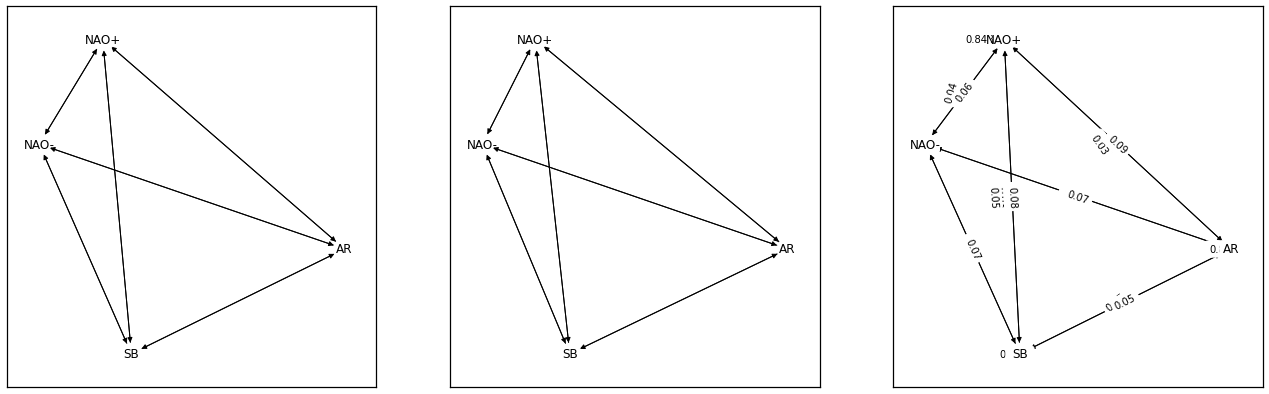

In [27]:
states = ['NAO+', 'NAO-', 'SB', 'AR']
fig, axs = plt.subplots(1,3,figsize=(22.5,7))
for ax, method in zip(axs.flat, stats.index):
    Q = stats.loc[method].values.reshape((4,4))
    Q = pd.DataFrame(Q, columns = states, index = states)
    def _get_markov_edges(Q):
        edges = {}
        for col in Q.columns:
            for idx in Q.index:
                edges[(idx,col)] = Q.loc[idx,col]
        return edges

    edges_wts = _get_markov_edges(Q)
    G = nx.MultiDiGraph()
    G.add_nodes_from(states)
    for k, v in edges_wts.items():
        tmp_origin, tmp_destination = k[0], k[1]
        G.add_edge(tmp_origin, tmp_destination, weight=v, label=v)

    pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='dot')
    nx.draw_networkx(G, pos, node_size = 500, node_color = '#ffffff', ax = ax,
                     cmap = 'RdBu_r', edge_cmap = 'RdBu_r', font_weight = 'medium')
    # create edge labels for jupyter plot but is not necessary
    edge_labels = {(n1,n2):d['label'] for n1,n2,d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G , pos, edge_labels=edge_labels)
    nx.drawing.nx_pydot.write_dot(G, 'mc_imgs/' + method +'.dot')
    (graph,) = pydot.graph_from_dot_file('mc_imgs/' + method +'.dot')
    graph.write_png('mc_imgs/' + method +'.png')
plt.show()

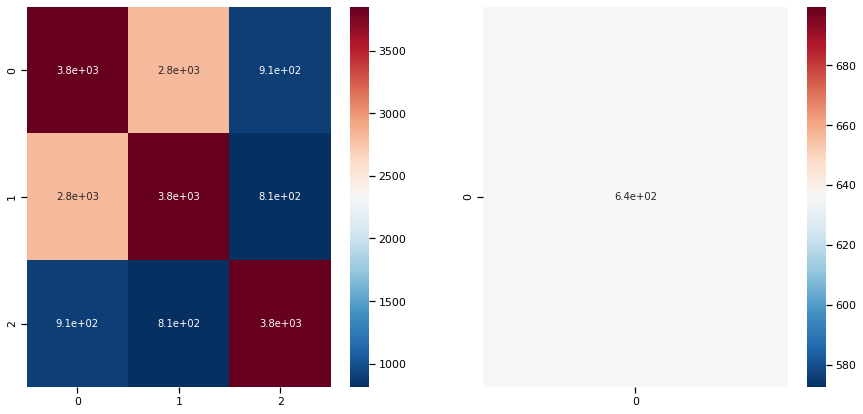

In [43]:
#def confusion_matrix(predictions):
preds = predictions.xs('Prediction', level =1, axis =1)
def count_occ(col_i,col_j):
    return sum(col_i == col_j)

conf_matrix = np.zeros((len(preds.columns), len(preds.columns)))
conf_matrix = np.fromfunction(lambda i,j: count_occ(preds.values[:,i], preds.values[:,j]),
                              (len(preds.columns), len(preds.columns)), dtype=int)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,7))
sns.heatmap(conf_matrix, ax = ax1, annot = True, cmap = "RdBu_r")
sns.heatmap(np.array([[sum(preds.eq(preds.iloc[:, 0], axis=0).all(1))]]), ax = ax2, annot = True, cmap = "RdBu_r")
plt.show()

### Temp for Trader

In [9]:
df = pd.read_csv("../src/dashboard/obs.csv", index_col = [0,1])

In [23]:
temp = df.groupby(df.index.get_level_values(1)).mean()
temp.index = pd.to_datetime(temp.index)
temp = temp[temp.index.month.isin([10,11,12,1,2,3])]
#temp['Normal'] = df.loc["1991-01-01":,'Temperature'].mean()
#temp[['Temperature', 'Normal']]

In [27]:
temp['Month'] = temp.index.month
temp = temp[['Month','Temperature']]
temp

Month  Temperature
Date                          
1979-01-01      1    -4.407315
1979-01-02      1    -4.418383
1979-01-03      1    -4.028732
1979-01-04      1    -3.627857
1979-01-05      1    -4.868678
...           ...          ...
2021-03-27      3     7.797197
2021-03-28      3     9.792516
2021-03-29      3    12.361500
2021-03-30      3    13.229949
2021-03-31      3    14.083873

[7745 rows x 2 columns]

In [29]:
normal = temp.groupby('Month').mean()

In [31]:
temp['Normal'] = temp.apply(lambda x: normal.loc[x['Month']], axis =1)

c:\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [33]:
temp['Anomaly'] = temp['Temperature'] - temp['Normal']

c:\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [45]:
anomaly = temp.groupby([temp.index.year, 'Month']).agg({'Anomaly': ['mean', 'std']})
anomaly.reset_index(level =1, inplace = True)

In [46]:
months = {1: "Jan", 2: "Feb", 3: "Mar", 10: "Oct", 11: "Nov", 12: "Dec"}
anomaly['Month'] = anomaly['Month'].map(months)
anomaly

Month   Anomaly          
                mean       std
Date                          
1979   Jan -3.748972  2.436474
1979   Feb -2.063680  1.814884
1979   Mar -1.269045  1.566106
1979   Oct -0.353572  2.722170
1979   Nov -1.115659  2.011314
...    ...       ...       ...
2020   Nov  1.628992  2.563605
2020   Dec  0.916413  2.090254
2021   Jan -0.318633  1.957794
2021   Feb  1.437529  3.996685
2021   Mar  0.279723  2.545817

[255 rows x 3 columns]

In [51]:
anomaly = anomaly.reset_index().set_index(['Date','Month'])

In [53]:
anomaly.to_csv("anomaly_temperature.csv")